# Estimation des émissions totales de GES et de la consommation d'énergie sur site en kBtu en fonction du score ENERGYSTAR

## Introduction

Dans ce projet, nous cherchons à estimer les émissions totales de gaz à effet de serre (GES) et la consommation d'énergie sur site en kBtu pour les bâtiments non destinés à l'habitation, en utilisant le score ENERGYSTAR. Le score ENERGYSTAR est un indicateur de performance énergétique qui évalue l'efficacité énergétique d'un bâtiment par rapport à des critères de référence. Nous cherchons à évaluer son utilité dans la prédiction des émissions et de la consommation d'énergie.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import cufflinks as cf 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import importlib.metadata
import time

# For Notebooks
init_notebook_mode(connected=True)
# For offline use
cf.go_offline()
%matplotlib inline

In [2]:
#Modification des affichages de colonnes, lignes et largeurs de colonnes pour avoir un maximum d'information
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [3]:
!python --version

# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

print("matplotlib - ", importlib.metadata.version('matplotlib'))

Python 3.8.3
pandas - 2.0.2
numpy - 1.23.5
seaborn - 0.12.1
missingno - 0.4.2
cufflinks - 0.17.3
matplotlib -  3.6.2


In [4]:
df=pd.read_csv('data_clean.csv')

In [5]:
df.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'Address',
       'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude',
       'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal_m2', 'PropertyGFAParking_m2',
       'PropertyGFABuilding(s)_m2', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA_m2',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA_m2',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA_m2',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'BuildingAge', 'SiteEnergyUse(kBtu)_total', 'YearGroup', 'SteamRatio',
     

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import set_config


# Copie des colonnes d'intérêt dans le DataFrame y
y = df.copy()[['log_energie','log_emission','TotalGHGEmissions', 'SiteEnergyUse(kBtu)']]

# Suppression des colonnes d'intérêt du DataFrame X
X = df.copy()
                   
X = X[X['ENERGYSTARScore'].isnull() == False]

y = y[y.index.isin(list(X.index))]

# Configuration de l'affichage
set_config(display='diagram')

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dans cette section, nous avons ajouté la colonne ENERGYSTARScore au jeu de données afin de vérifier les performances de XGBoost. Cependant, il manque plusieurs colonnes dans le jeu de données, ce qui réduit sa taille.

In [13]:
X_train.shape 

(781, 63)

In [15]:
X_test.shape

(196, 63)

La taille des données d'entraînement est passée de 1210 à 781, tandis que la taille de données de test est passée de 303 à 196.

In [7]:
# Définition des noms des colonnes catégorielles et numériques
cat_cols = ['Neighborhood', 'BuildingType', 'ZipCode']
num_cols = [
    'BuildingAge',
    'MeanGFAperFloor',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal_m2',
    'PropertyGFAParking_m2',
    'PropertyGFABuilding(s)_m2',
    'NumYearsENERGYSTARCertified',
    'YearsSinceCertified'
]

other_col = [
    'most_steam',
    'most_electricity',
    'most_gas',
    'Miscellaneous Facilities_ratio',
    'Entertainment and Recreation Facilities_ratio',
    'Educational Facilities_ratio',
    'Commercial Facilities_ratio',
    'Industrial Facilities_ratio',
    'Healthcare Facilities_ratio',
    'Residential Facilities_ratio',
    'ParkingGFARatio',
    'SLP_Ratio',
    'TLP_Ratio',
    'SteamRatio',
    'ElectricityRatio',
    'NaturalGasRatio',
    'ENERGYSTARScore'
]

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
import xgboost as xgb


# Création du transformateur de colonnes avec encodage target
target_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_cols),  # Standardisation des colonnes numériques
        ('target', TargetEncoder(), cat_cols),  # Encodage target des colonnes catégorielles
        ('passthrough', 'passthrough', other_col)  # Passthrough des autres colonnes
    ],
    remainder='drop'
)

# Define the parameters for XGBoost
param_xgb = {
     'n_estimators': [800, 1000], 
    # Nombre d'estimateurs dans l'ensemble (plus d'estimateurs peuvent améliorer
    # les performances mais augmentent le temps d'entraînement)
     'learning_rate': [0.1, 0.01], 
# Taux d'apprentissage (contrôle l'ampleur des mises à jour de modèle à chaque étape d'apprentissage)
     'max_depth': [3, 5],  # Profondeur maximale de chaque arbre dans l'ensemble
     'subsample': [0.8],  # Sous-échantillonnage des échantillons d'entraînement pour chaque arbre
     'colsample_bytree': [0.8],  # Sous-échantillonnage des colonnes (variables) pour chaque arbre
     'gamma': [0.1],  # Seuil pour effectuer une division d'un nœud de l'arbre
     'reg_alpha': [0],  # Terme de régularisation L1 (Lasso) pour les poids des feuilles de l'arbre
     'reg_lambda': [0.2]  # Terme de régularisation L2 (Ridge) pour les poids des feuilles de l'arbre
}

# Create the grid search object
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_xgb,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('column_transformer', target_transformer),
    ('grid_search', xgb_grid_search)
])




Voici les performances des données d'entraînement avec la variable ENERGYSTARScore :



In [9]:
def print_encoding_results(pipeline, encoding_name, target):
    start_time = time.time()
    model = pipeline.fit(X_train, target)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = model.named_steps['grid_search'].best_params_
    best_mae_score = np.max(model.named_steps['grid_search'].cv_results_['mean_test_neg_mean_absolute_error'])
    best_r2_score = model.named_steps['grid_search'].best_score_
    
    print("Meilleurs paramètres ({}) :".format(encoding_name), best_params)
    print("Meilleur score MAE ({}) :".format(encoding_name), '{:.3f}'.format(best_mae_score))
    print("Meilleur score R2 ({}) :".format(encoding_name), '{:.3f}'.format(best_r2_score))
    print("Temps d'entraînement ({}) : {:.2f} secondes".format(encoding_name, training_time))



encodings = [("XGBoost", xgb_pipeline)]

target_variables = [("TotalGHGEmissions", y_train['log_emission']),
                    ("SiteEnergyUse(kBtu)", y_train['log_energie'])]

for encoding_name, pipeline in encodings:
    for target_name, target_variable in target_variables:
        print("Encoding:", encoding_name)
        print("Target Variable:", target_name)
        print_encoding_results(pipeline, encoding_name, target_variable)
        print()

Encoding: XGBoost
Target Variable: TotalGHGEmissions
Meilleurs paramètres (XGBoost) : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0.2, 'subsample': 0.8}
Meilleur score MAE (XGBoost) : -0.360
Meilleur score R2 (XGBoost) : 0.865
Temps d'entraînement (XGBoost) : 6.23 secondes

Encoding: XGBoost
Target Variable: SiteEnergyUse(kBtu)
Meilleurs paramètres (XGBoost) : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0, 'reg_lambda': 0.2, 'subsample': 0.8}
Meilleur score MAE (XGBoost) : -0.326
Meilleur score R2 (XGBoost) : 0.846
Temps d'entraînement (XGBoost) : 4.57 secondes



Et voici les résultats des données de test avec la variable ENERGYSTARScore :



In [16]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(np.abs(diff))
    r2 = 1 - (np.sum(diff**2) / np.sum((y_true - np.mean(y_true))**2))
    dict_metrics = {"Métrique": ["MAE", "R²"], "Résultats": [mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    df_metrics['Résultats'] = df_metrics['Résultats'].apply(lambda x: '{:.3f}'.format(x))
    return df_metrics

def calculate_metrics(encoding_pipeline, target_variable):
    model = encoding_pipeline.fit(X_train, y_train[target_variable])
    predictions = model.predict(X_test)
    metrics = metrics_model(y_test[target_variable], predictions)
    metrics['Résultats'] = metrics['Résultats']
    return metrics

target_variables = ["log_emission", "log_energie"]

for encoding_name, encoding_pipeline in encodings:
    print("Encodage :", encoding_name)
    for target_variable in target_variables:
        print("Variable cible :", target_variable)
        metrics = calculate_metrics(encoding_pipeline, target_variable)
        print(metrics)
        print()


Encodage : XGBoost
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.310
1       R²     0.896

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.308
1       R²     0.860



Il est intéressant de noter que le meilleur score R² obtenu avec la variable ENERGYSTARScore est meilleur que le précédent. Cependant, il convient de souligner que cette analyse a été effectuée sur un ensemble de données plus restreint. Afin de mesurer l'effet de la variable ENERGYSTARScore, je vais répéter l'analyse une fois sans la prendre en compte.

In [17]:
def plot_pred_true(y_true, y_pred, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode='markers',
                             marker=dict(color="#9C3E2D", opacity=0.6), name="Predicted Values"))
    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()], y=[y_true.min(), y_true.max()],
                             mode='lines', line=dict(color='red'), name="Bisector"))
    fig.update_layout(xaxis_title="True Values", yaxis_title="Predicted Values",
                      title="Predicted Values vs True Values | Variable {}".format(title), font=dict(size=12))
    return fig

# Créer une figure avec 1 ligne et 2 colonnes
fig = make_subplots(rows=1, cols=2)

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "TotalGHGEmissions" 
# en utilisant XGBoost
xgb_model_GHG = xgb_pipeline.fit(X_train, y_train['log_emission'])
GHG_pred_xgb = xgb_model_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], GHG_pred_xgb, title="TotalGHGEmissions (XGBoost)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.05, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions (XGBoost)",\
                   showarrow=False, font=dict(size=18))

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "SiteEnergyUse(kBtu)" 
# en utilisant RandomForestRegressor
xgb_model_SUE = xgb_pipeline.fit(X_train, y_train['log_energie'])
SiteEnergy_pred_xgb = xgb_model_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], SiteEnergy_pred_xgb, title="SiteEnergyUse(kBtu) (XGBoost)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.99, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu) (XGBoost)",\
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Valeurs prédites vs Valeurs réelles | Pipelines d'apprentissage automatique",\
                  height=500, width=1000)
fig.show()



J'ai également tracé les valeurs en transformant les valeurs logarithmiques en leurs valeurs d'origine. Voici le code pour tracer les prédictions par rapport aux valeurs réelle.

In [18]:
plot_pred_true(y_test['TotalGHGEmissions'], np.exp(GHG_pred_xgb), title="TotalGHGEmissions (XGBoost)")


In [19]:
metrics_model(y_test['TotalGHGEmissions'], np.exp(GHG_pred_xgb))

Métrique Résultats
0      MAE    36.278
1       R²     0.793

In [20]:
plot_pred_true(y_test['SiteEnergyUse(kBtu)'], np.exp(SiteEnergy_pred_xgb), title="SiteEnergyUse(kBtu) (XGBoost)")


In [21]:
metrics_model(y_test['SiteEnergyUse(kBtu)'],np.exp(SiteEnergy_pred_xgb))

Métrique    Résultats
0      MAE  1601696.544
1       R²        0.832

# Feature Importances

In [22]:
# Ajuster le column transformer sur les données d'entraînement
target_transformer.fit_transform(X_train, y_train['log_emission'])

# Obtenir les noms des colonnes transformées
transformed_col_names = num_cols + list(target_transformer.named_transformers_['target'].\
                                        get_feature_names_out(cat_cols)) + other_col

# Afficher les noms des colonnes résultants
display(transformed_col_names)

['BuildingAge',
 'MeanGFAperFloor',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal_m2',
 'PropertyGFAParking_m2',
 'PropertyGFABuilding(s)_m2',
 'NumYearsENERGYSTARCertified',
 'YearsSinceCertified',
 'Neighborhood',
 'BuildingType',
 'ZipCode',
 'most_steam',
 'most_electricity',
 'most_gas',
 'Miscellaneous Facilities_ratio',
 'Entertainment and Recreation Facilities_ratio',
 'Educational Facilities_ratio',
 'Commercial Facilities_ratio',
 'Industrial Facilities_ratio',
 'Healthcare Facilities_ratio',
 'Residential Facilities_ratio',
 'ParkingGFARatio',
 'SLP_Ratio',
 'TLP_Ratio',
 'SteamRatio',
 'ElectricityRatio',
 'NaturalGasRatio',
 'ENERGYSTARScore']

In [23]:
X_train_encoded = pd.DataFrame(target_transformer.transform(X_train), columns=transformed_col_names)
X_test_encoded = pd.DataFrame(target_transformer.transform(X_test), columns=transformed_col_names)

In [24]:
# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

def plot_feature_importance(X, y, target_name):
    # Fit the XGBoost pipeline and get the best estimator
    xgb_pipeline.fit(X, y)
    xp = xgb_pipeline.steps[-1][1].best_estimator_

    # Perform feature importance analysis
    sorted_indices = np.argsort(xp.feature_importances_)
    sorted_importances = xp.feature_importances_[sorted_indices]
    sorted_col_names = [transformed_col_names[i] for i in sorted_indices]

    # Plot the feature importances
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_importances)), sorted_importances,
                color=["red" if importance < 0 else "green" for importance in sorted_importances])
        ax.set_yticks(range(len(sorted_col_names)))
        ax.set_yticklabels(sorted_col_names, fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Feature Importance ({target_name})", fontsize=25, fontweight='bold')

    plt.show()



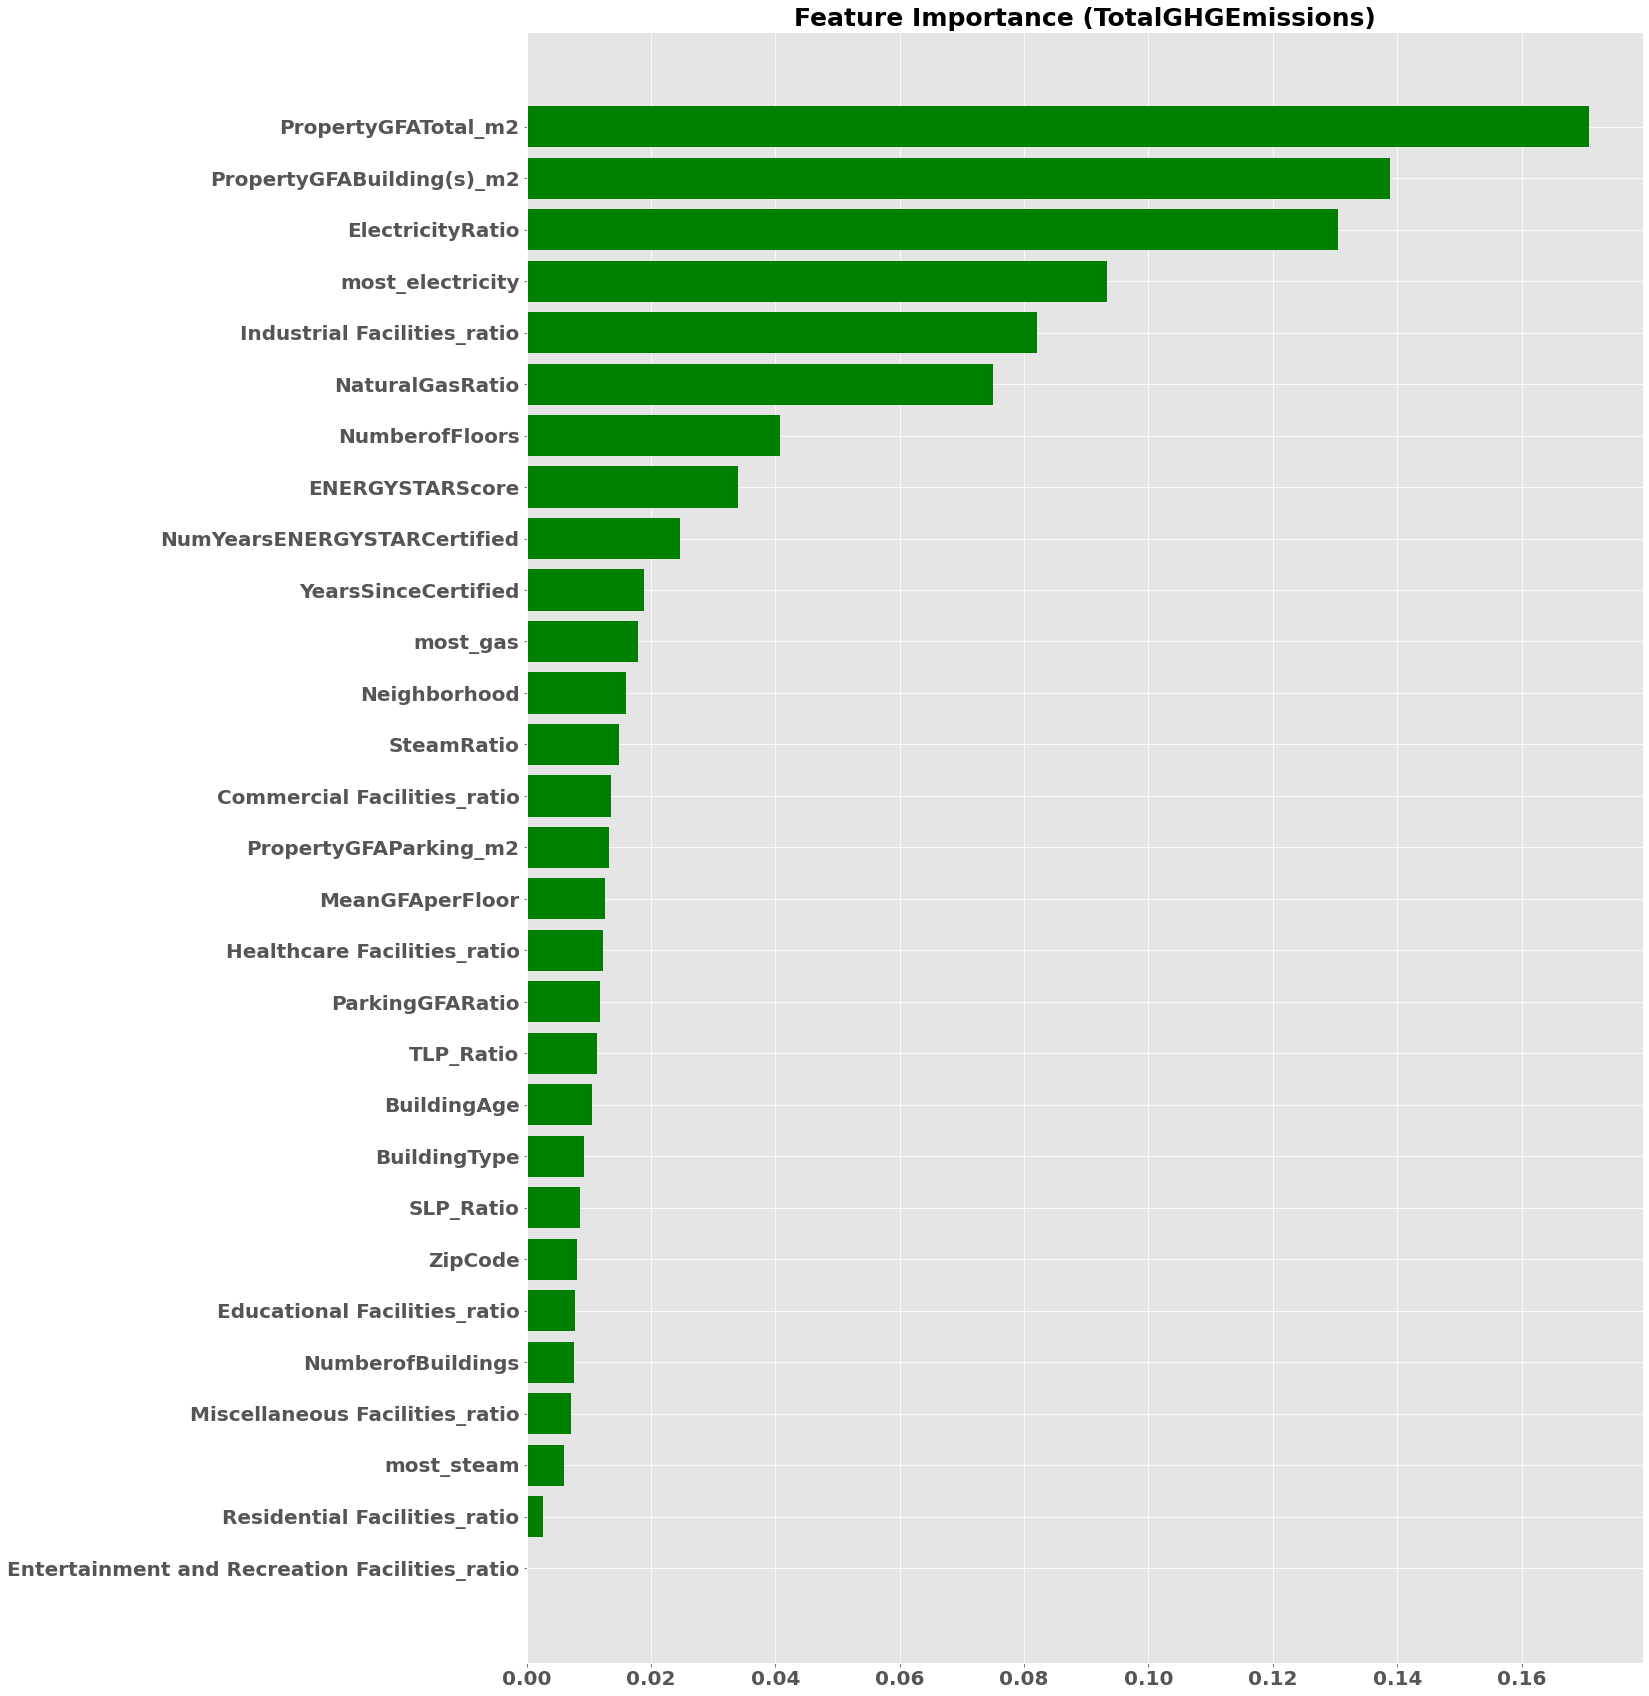

In [25]:
# Tracer l'importance des caractéristiques pour la colonne 'TotalGHGEmissions'
plot_feature_importance(X_train_encoded, y_train['log_emission'], 'TotalGHGEmissions')

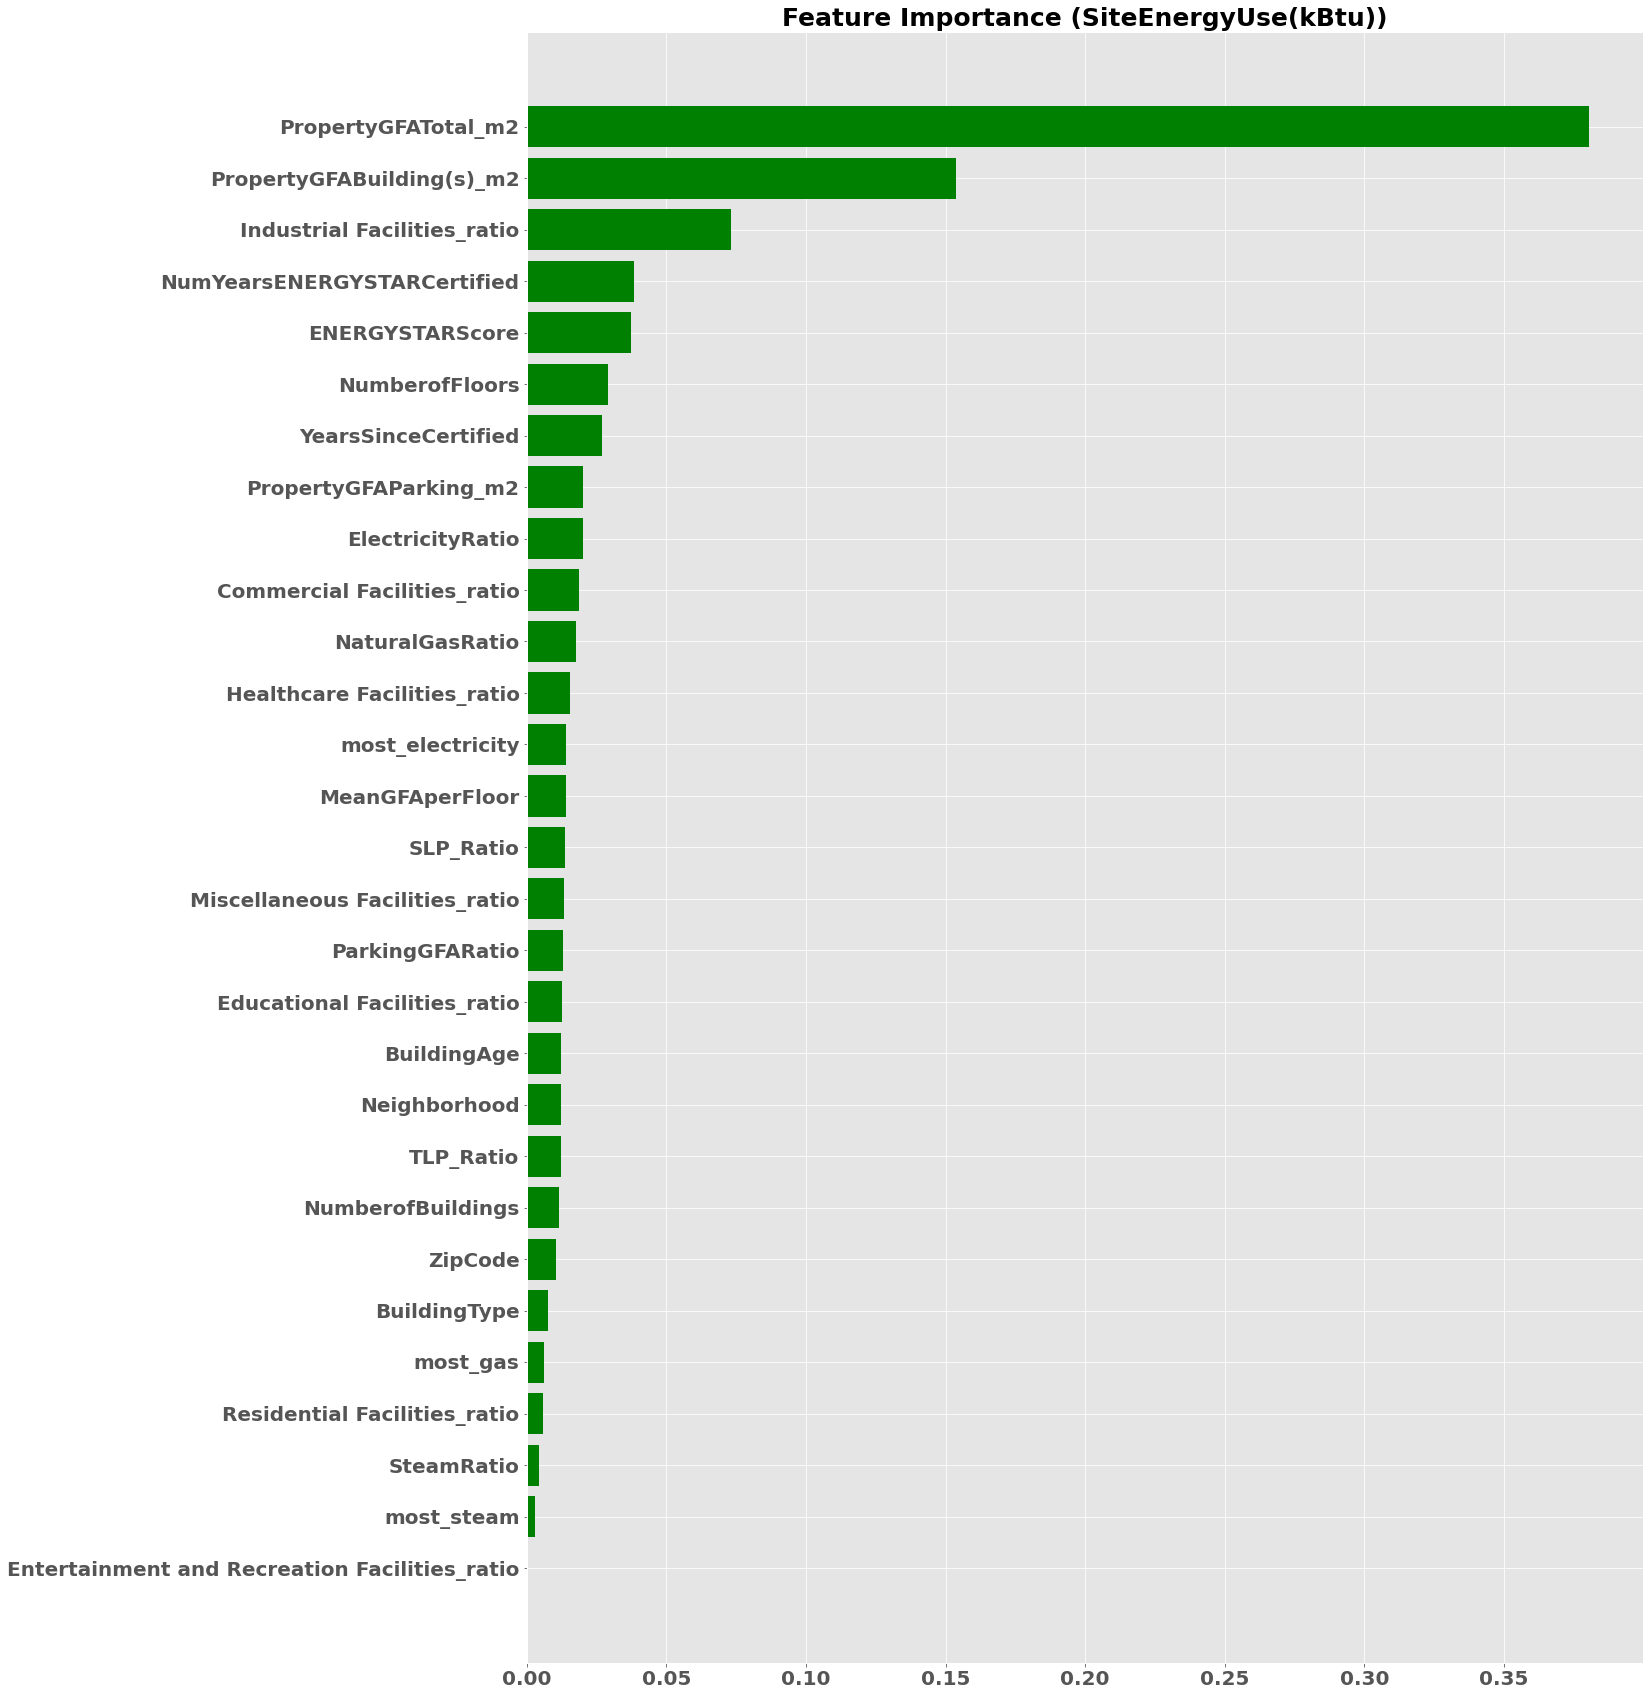

In [27]:
# Tracer l'importance des caractéristiques pour la colonne 'SiteEnergyUse(kBtu)'
plot_feature_importance(X_train_encoded, y_train['log_energie'], 'SiteEnergyUse(kBtu)')

Dans le calcul de l'importance des caractéristiques, la valeur de l'ENERGYSTARScore occupe la 8ème position, du plus élevé au plus bas, pour la prédiction de log_emission. Quant à la prédiction de log_energie, cette valeur occupe la 5ème position en termes d'importance des caractéristiques. Cela signifie que l'ENERGYSTARScore joue un rôle significatif dans la prédiction de ces deux variables cibles, mais il est moins important que d'autres caractéristiques.

## Lime

In [28]:
import lime
from lime import lime_tabular

lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

lime_xgb_pipeline.fit(X_train_encoded, y_train['log_emission'])
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                              feature_names=transformed_col_names)


In [29]:
import random
idx = random.randint(1, len(X_test_encoded))

print("Prediction: ", lime_xgb_pipeline.predict(X_test_encoded.iloc[[idx]].values))
print("Actual:     ", y_test.iloc[idx]['log_emission'])

explanation = explainer.explain_instance(X_test_encoded.iloc[[idx]].values[0], lime_xgb_pipeline.predict,
                                         num_features=len(transformed_col_names))


Prediction:  [2.7880313]
Actual:      3.039749158970765


In [30]:
explanation.show_in_notebook()


In [31]:
lime_xgb_pipeline.fit(X_train_encoded, y_train['log_energie'])
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                              feature_names=transformed_col_names)
explanation = explainer.explain_instance(X_test_encoded.iloc[[idx]].values[0], lime_xgb_pipeline.predict,
                                         num_features=len(transformed_col_names))
explanation.show_in_notebook()

In [32]:
from matplotlib.ticker import FixedLocator, FixedFormatter

lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

def plot_lime_feature_importance(column_name):
    # Fit the XGBoost pipeline and get the best estimator
    lime_xgb_pipeline.fit(X_train_encoded, y_train[column_name])
    lxp = lime_xgb_pipeline.steps[-1][1].best_estimator_

    # Define the LimeTabularExplainer
    explainer = lime_tabular.LimeTabularExplainer(X_train_encoded.values, mode="regression",
                                                  feature_names=transformed_col_names)
    explanations = [explainer.explain_instance(instance,
                                               lxp.predict,
                                               num_features=len(transformed_col_names))
                    for instance in X_test_encoded.values]

    # Calculate feature importances
    feature_importances = [exp.as_list() for exp in explanations]
    feature_importances = dict(sum(feature_importances, []))

    # Sort feature importances by absolute value
    sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=False)

    # Plot feature importances
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.barh(range(len(sorted_importances)), [val for _, val in sorted_importances],
            color=["red" if val < 0 else "green" for _, val in sorted_importances])
    ax.set_yticks(range(len(sorted_importances)))
    ax.set_yticklabels([name for name, _ in sorted_importances], fontsize=20, fontweight='bold')
    ax.tick_params(axis='x', labelsize=20)
    ax.set_xticklabels(ax.get_xticks(), fontsize=20, fontweight='bold')
    ax.set_title("Feature Importance (Lime) - " + column_name, fontsize=25, fontweight='bold')

    # Fix the y-axis tick locations and labels
    ax.yaxis.set_major_locator(FixedLocator(range(len(sorted_importances))))
    ax.yaxis.set_major_formatter(FixedFormatter([name for name, _ in sorted_importances]))

    plt.show()

<ipython-input-32-af0c2dc6c073>:34: UserWarning:

FixedFormatter should only be used together with FixedLocator



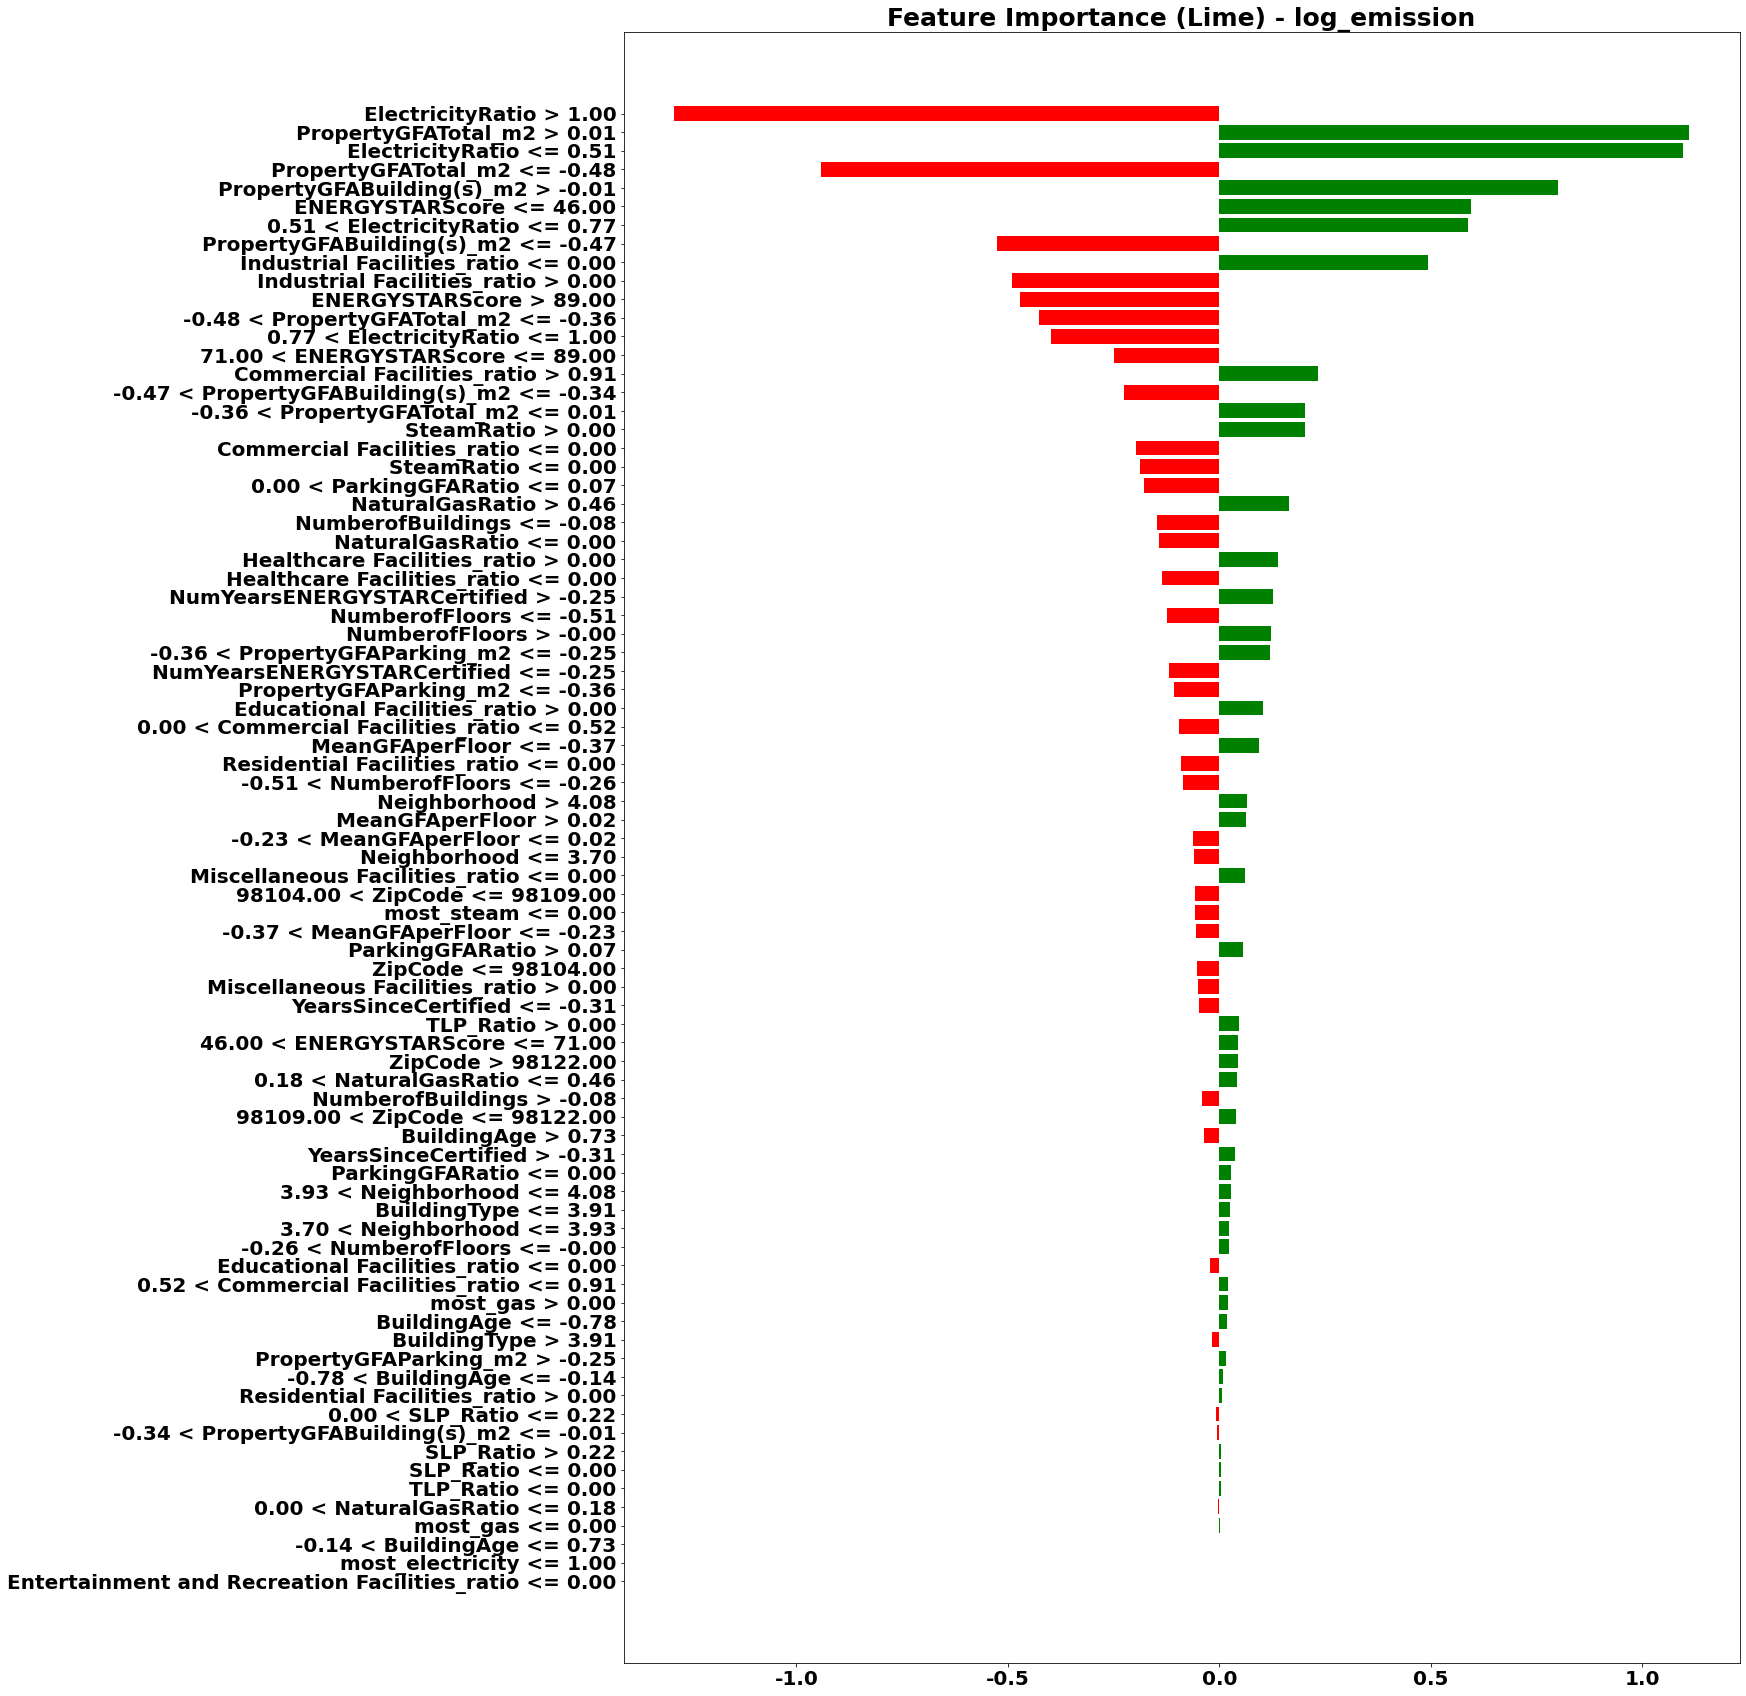

In [33]:
# Call the function for 'TotalGHGEmissions' column
plot_lime_feature_importance('log_emission')

Les valeurs ENERGYSTAR inférieures à 46 qui donnent des valeurs LIME positives élevées indiquent que ces bâtiments ont tendance à avoir des émissions plus élevées que prévu en se basant uniquement sur les autres caractéristiques. Cela peut être dû à des facteurs tels qu'une faible efficacité énergétique, des équipements obsolètes ou des pratiques de gestion inadéquates.

D'autre part, les valeurs ENERGYSTAR supérieures à 89 qui donnent les valeurs LIME négatives les plus élevées suggèrent que ces bâtiments ont des émissions inférieures à ce qui serait attendu compte tenu des autres caractéristiques. Cela peut être dû à une bonne efficacité énergétique, l'utilisation de technologies avancées ou des pratiques de gestion durables.



La raison derrière cela pourrait être que les bâtiments ayant un ratio d'électricité plus élevé, une taille plus petite (GFA plus basse), un score ENERGYSTAR plus élevé et des installations industrielles ont tendance à mettre en place des mesures d'efficacité énergétique. Ces mesures peuvent inclure des équipements efficaces, une isolation, l'utilisation d'énergies renouvelables ou des pratiques de gestion énergétique optimisées. Par conséquent, on s'attend à ce que ces bâtiments aient des émissions plus faibles, ce qui se reflète dans les prédictions du modèle avec des valeurs LIME négatives élevées.

<ipython-input-32-af0c2dc6c073>:34: UserWarning:

FixedFormatter should only be used together with FixedLocator



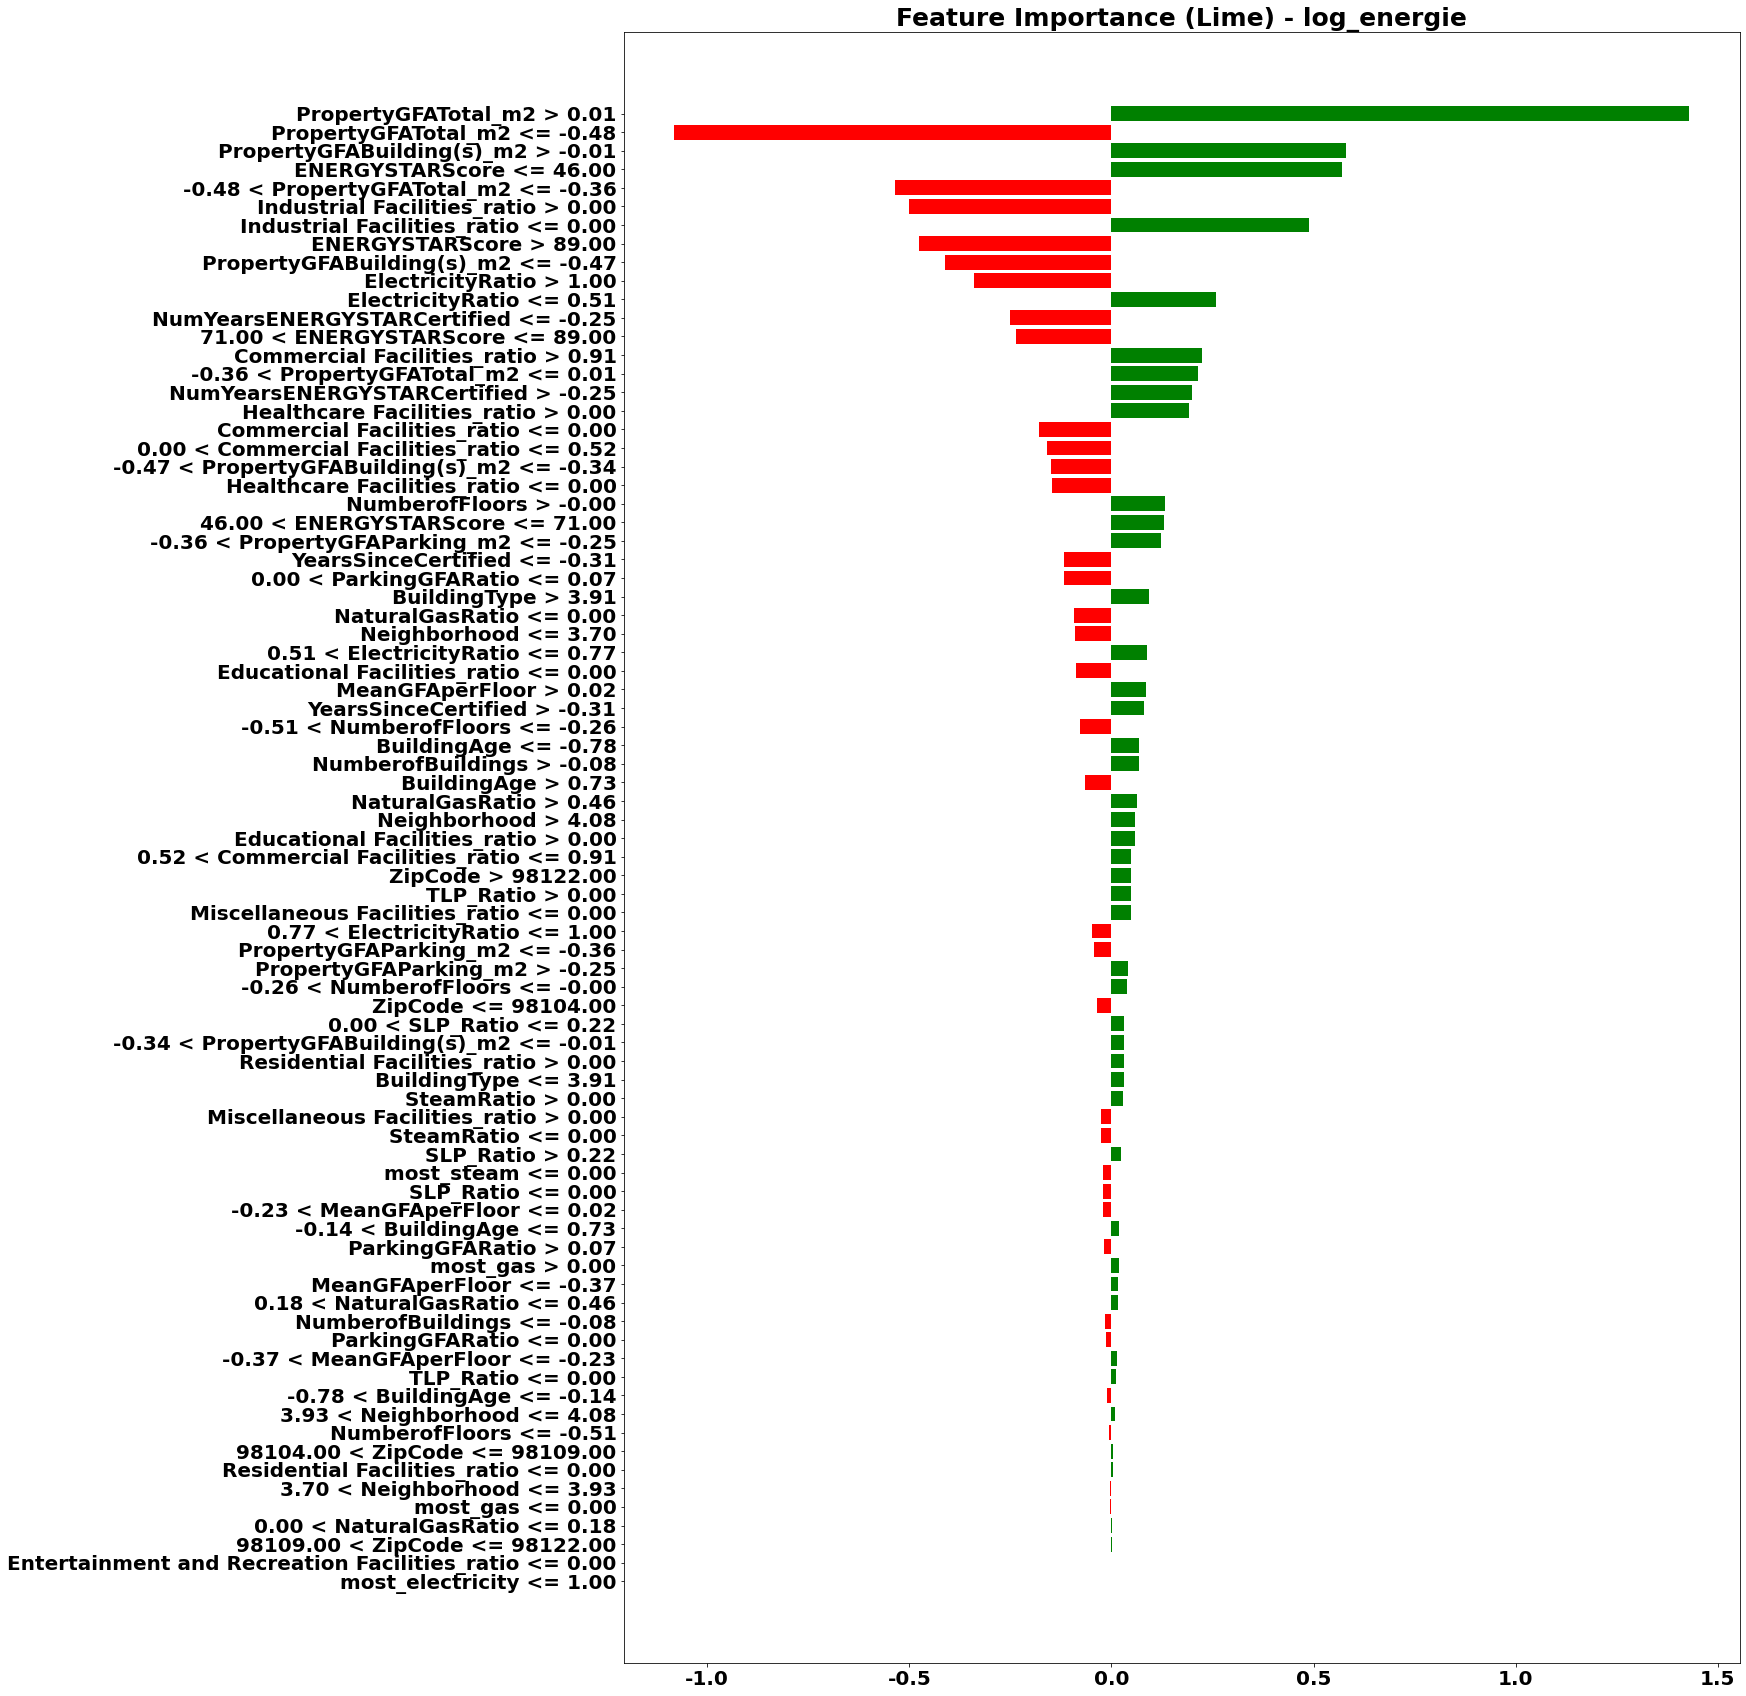

In [34]:
# Call the function for 'SiteEnergyUse(kBtu)' column
plot_lime_feature_importance('log_energie')

## SHAP

In [36]:
import shap
import warnings
warnings.filterwarnings("ignore")

In [37]:
shap.initjs()


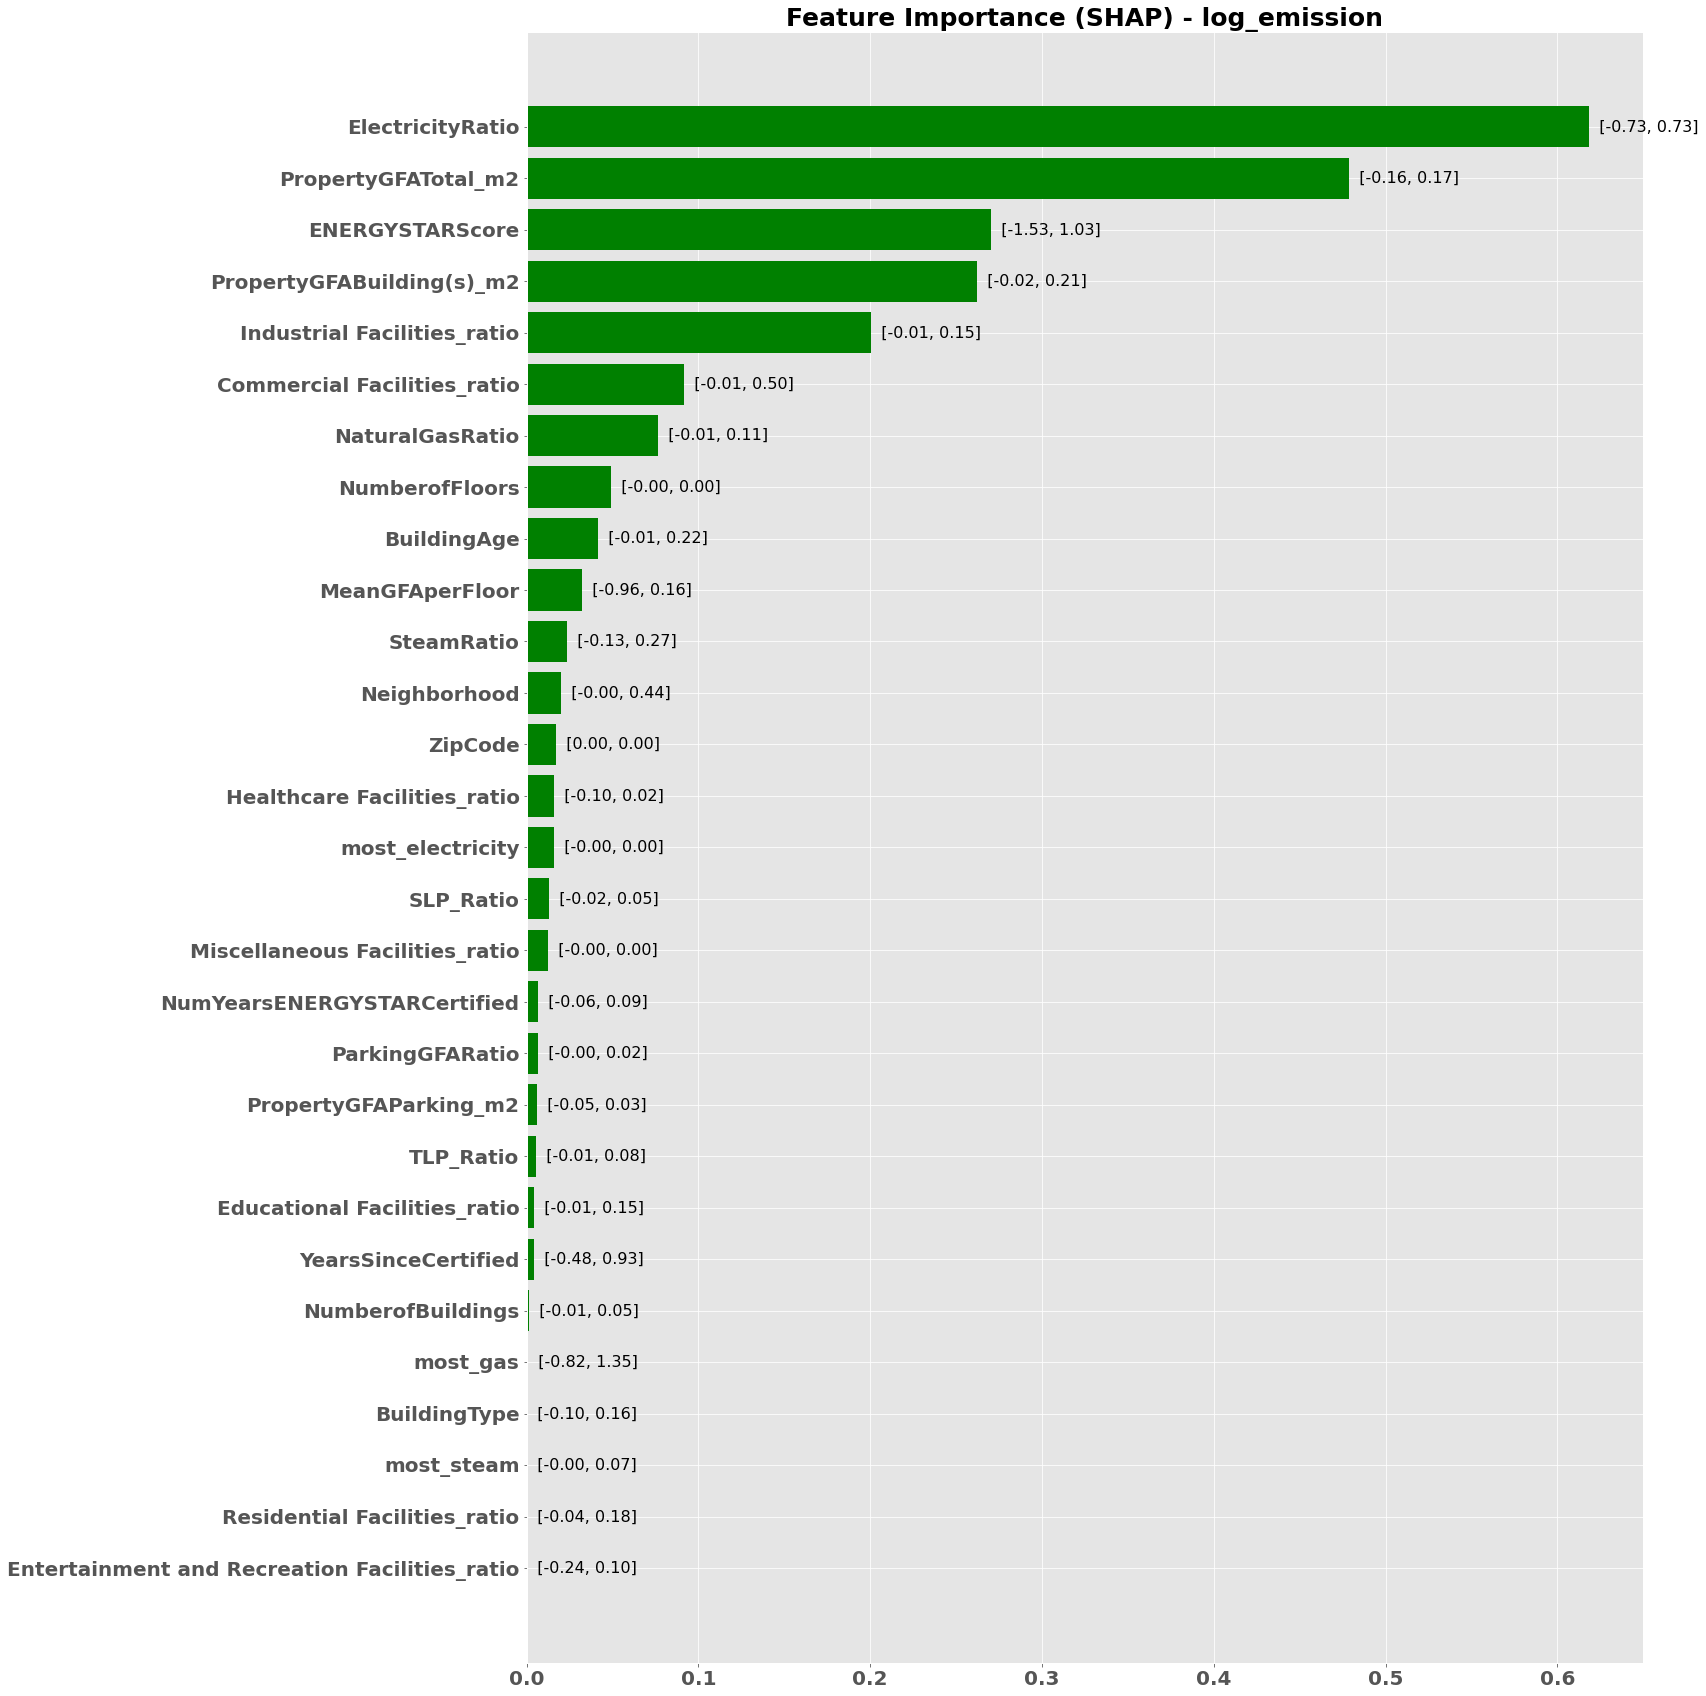

In [38]:
def plot_shap_feature_importance(column_name):
    # Create the XGBoost pipeline
    shap_xgb_pipeline = Pipeline([
        ('grid_search', xgb_grid_search)
    ])

    shap_xgb_pipeline.fit(X_train_encoded, y_train[column_name])
    sxp = shap_xgb_pipeline.steps[-1][1]
    sxp = sxp.best_estimator_

    # SHAP feature importance
    explainer = shap.TreeExplainer(sxp)
    shap_values = explainer.shap_values(X_test_encoded)

    # Calculate SHAP feature importances
    shap_feature_importances = np.abs(shap_values).mean(axis=0)
    sorted_shap_importances = sorted(zip(transformed_col_names, shap_feature_importances), key=lambda x: x[1], reverse=False)

    # Plot SHAP feature importances
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_shap_importances)), [val for _, val in sorted_shap_importances], color="green")
        ax.set_yticks(range(len(sorted_shap_importances)))
        ax.set_yticklabels([name for name, _ in sorted_shap_importances], fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Feature Importance (SHAP) - {column_name}", fontsize=25, fontweight='bold')

        # Add data range information
        for i, (_, importance) in enumerate(sorted_shap_importances):
            min_value = np.min(shap_values[:, i])
            max_value = np.max(shap_values[:, i])
            ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

    plt.show()

# Call the function for 'TotalGHGEmissions' column
plot_shap_feature_importance('log_emission')


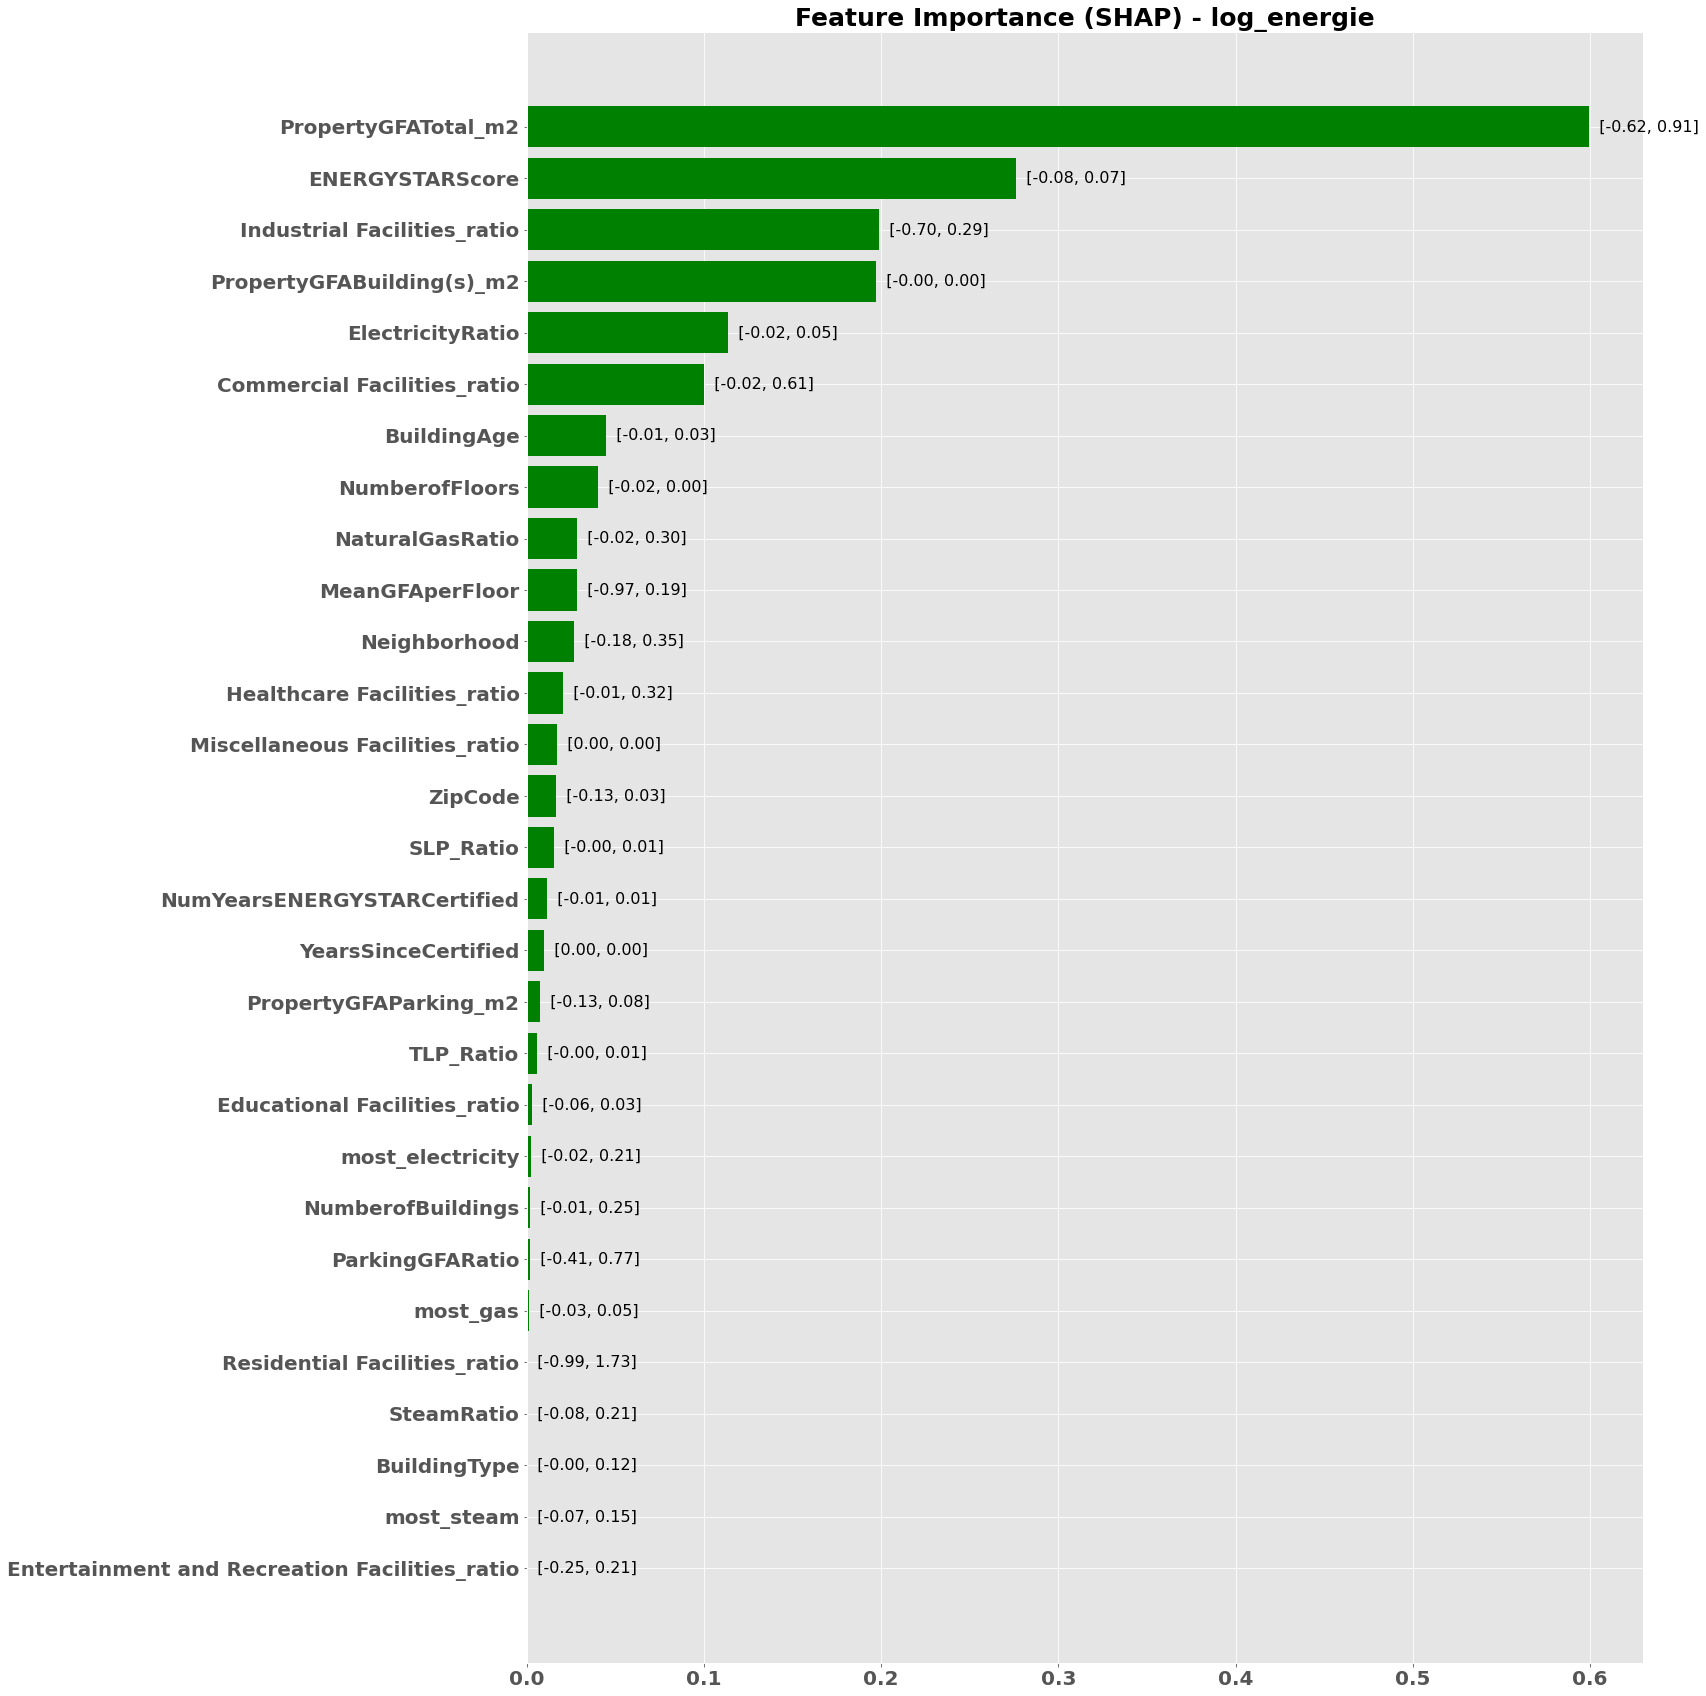

In [39]:
# Call the function for 'SiteEnergyUse(kBtu)' column
plot_shap_feature_importance('log_energie')

Lorsque nous avons examiné les valeurs SHAP absolues, nous avons constaté que le score ENERGYSTAR était classé en 3e position dans la prédiction des émissions et en 2e position dans la prédiction de la consommation d'énergie. Cela indique que le score ENERGYSTAR a une influence significative sur les deux variables cibles.

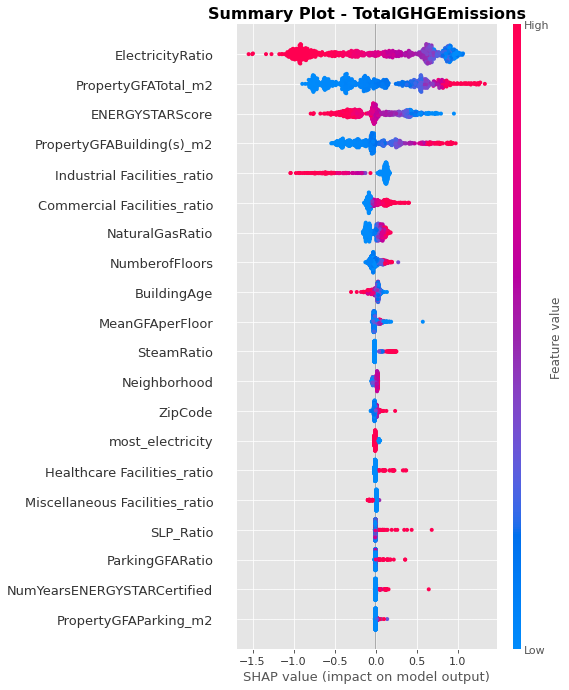

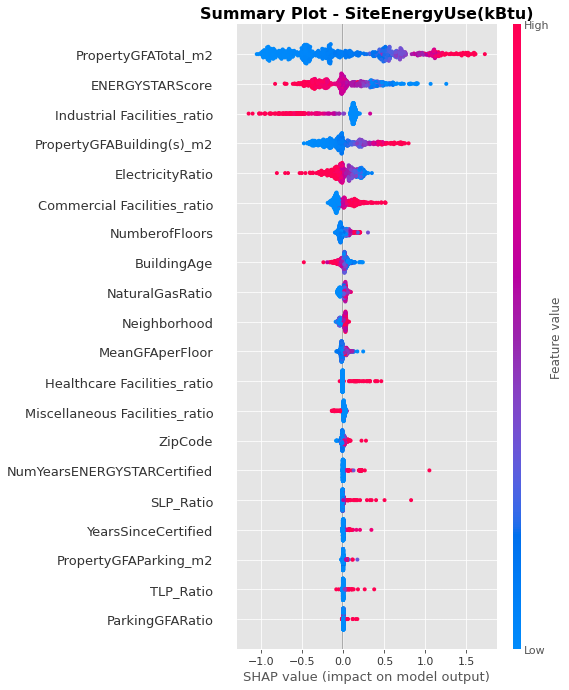

In [40]:
import shap

def generate_summary_plot(X, y, transformed_col_names, target_name):
    # Create the XGBoost pipeline
    xgb_pipeline = Pipeline([
        ('grid_search', xgb_grid_search)
    ])
    
    # Fit the XGBoost pipeline and get the best estimator
    xgb_pipeline.fit(X, y)
    xp = xgb_pipeline.steps[-1][1].best_estimator_
    
    # Create the SHAP explainer and calculate the SHAP values
    explainer = shap.TreeExplainer(xp)
    shap_values = explainer.shap_values(X)
    
    # Create the summary plot
    with plt.style.context("ggplot"):
        shap.summary_plot(shap_values, X, feature_names=transformed_col_names, show=False)
        plt.title("Summary Plot - " + target_name, fontsize=16, fontweight='bold')
        plt.show()

# Generate summary plot for 'TotalGHGEmissions'
generate_summary_plot(X_train_encoded, y_train['log_emission'], transformed_col_names, 'TotalGHGEmissions')

# Generate summary plot for 'SiteEnergyUse(kBtu)'
generate_summary_plot(X_train_encoded, y_train['log_energie'], transformed_col_names, 'SiteEnergyUse(kBtu)')



In [41]:
def plot_dependence_shap(X_train, X_test, y_train, column_name, transformed_col_names, features_to_plot):
    # Create the XGBoost pipeline
    shap_xgb_pipeline = Pipeline([('grid_search', xgb_grid_search)])

    # Fit the XGBoost pipeline to obtain the best estimator
    shap_xgb_pipeline.fit(X_train, y_train[column_name])
    sxp = shap_xgb_pipeline.steps[-1][1].best_estimator_

    # Create the SHAP TreeExplainer
    explainer = shap.TreeExplainer(sxp)

    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test)

    # Generate dependence plots for the selected features
    with plt.style.context("ggplot"):
        for feature in features_to_plot:
            shap.dependence_plot(feature, shap_values, X_test, feature_names=transformed_col_names, show=False)
            plt.title(f"Dependence Plot - {feature} ({column_name})", fontsize=16, fontweight='bold')
            plt.scatter(X_test[feature], y_test[column_name], color='red', alpha=0.3)
            plt.show()

# Specify the features to plot for dependence plots
features_to_plot = ['ElectricityRatio', 'PropertyGFATotal_m2','ENERGYSTARScore']



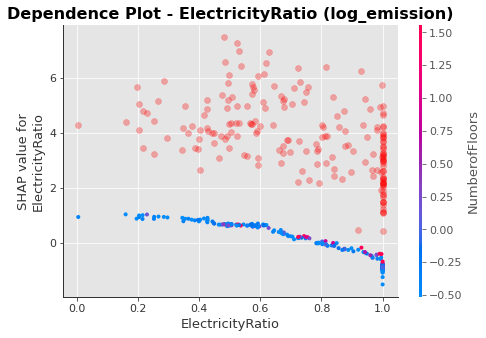

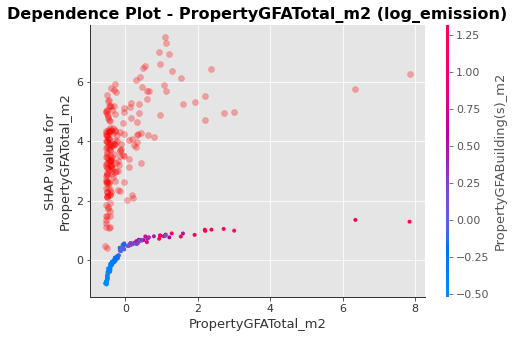

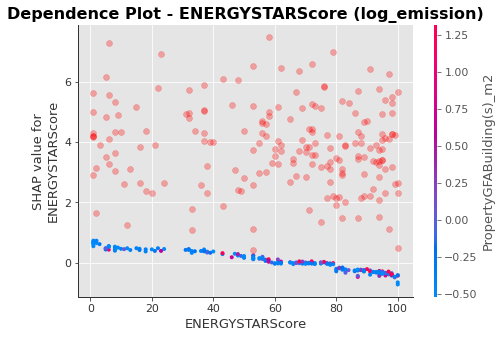

In [42]:
# Call the function for the 'TotalGHGEmissions' target
plot_dependence_shap(X_train_encoded, X_test_encoded, y_train, 'log_emission', transformed_col_names, features_to_plot)


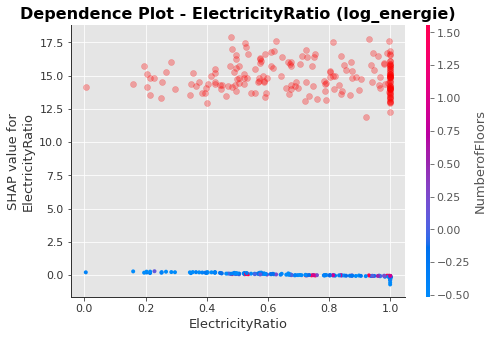

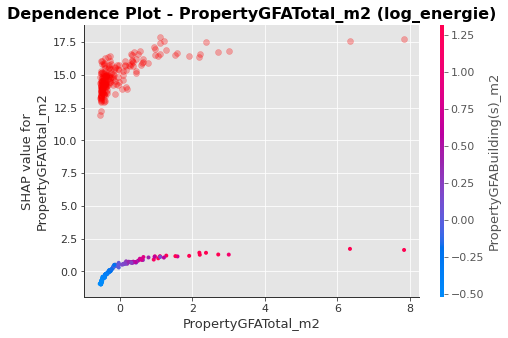

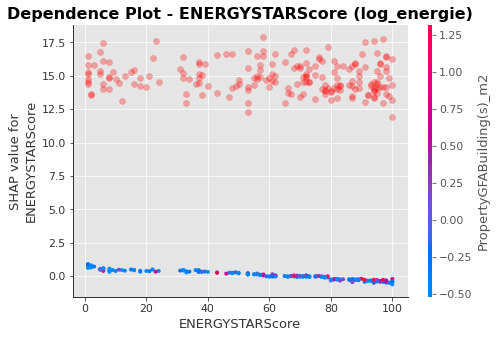

In [43]:
# Call the function for the 'SiteEnergyUse(kBtu)' target
plot_dependence_shap(X_train_encoded, X_test_encoded, y_train, 'log_energie', transformed_col_names, features_to_plot)


Using 781 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/196 [00:00<?, ?it/s]

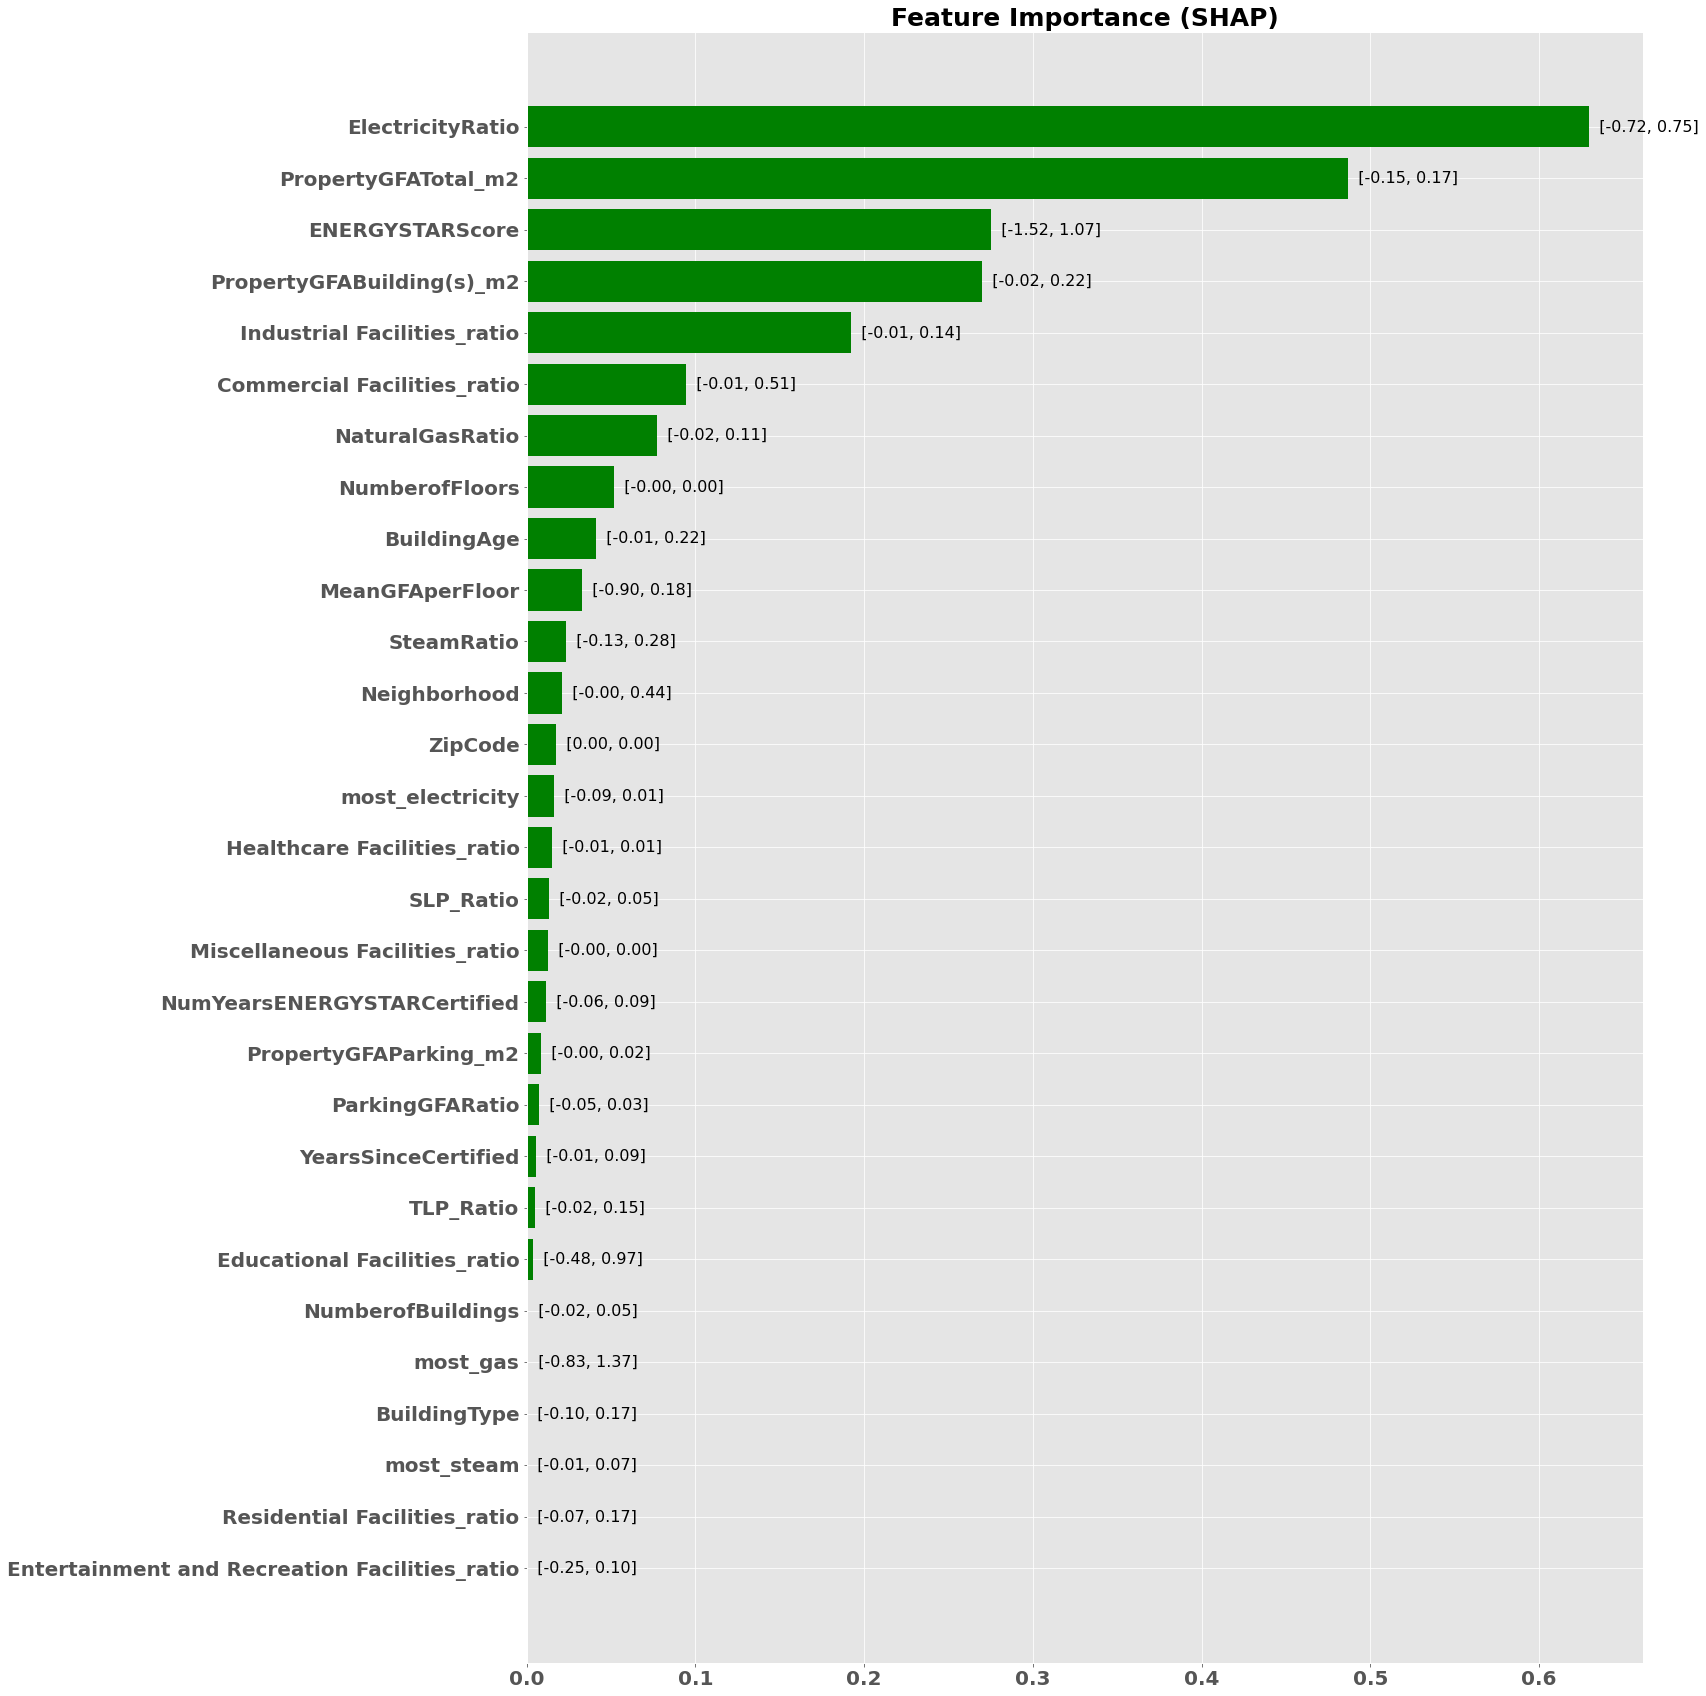

In [44]:
# Create the XGBoost pipeline
lime_xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

lime_xgb_pipeline.fit(X_train_encoded, y_train['log_emission'])
lxp = lime_xgb_pipeline.steps[-1][1]
lxp = lxp.best_estimator_

# Background data summarization
background_summary = shap.sample(X_train_encoded, len(X_train_encoded))

# Kernel SHAP feature importance
explainer = shap.KernelExplainer(lxp.predict, background_summary)
shap_values = explainer.shap_values(X_test_encoded)

# Calculate SHAP feature importances
shap_feature_importances = np.abs(shap_values).mean(axis=0)
sorted_shap_importances = sorted(zip(transformed_col_names, shap_feature_importances), key=lambda x: x[1], reverse=False)

# Plot SHAP feature importances
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.barh(range(len(sorted_shap_importances)), [val for _, val in sorted_shap_importances], color="green")
    ax.set_yticks(range(len(sorted_shap_importances)))
    ax.set_yticklabels([name for name, _ in sorted_shap_importances], fontsize=20, fontweight='bold')
    plt.xticks(fontsize=20, fontweight='bold')
    ax.set_title("Feature Importance (SHAP)", fontsize=25, fontweight='bold')

    # Add data range information
    for i, (_, importance) in enumerate(sorted_shap_importances):
        min_value = np.min(shap_values[:, i])
        max_value = np.max(shap_values[:, i])
        ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

plt.show()


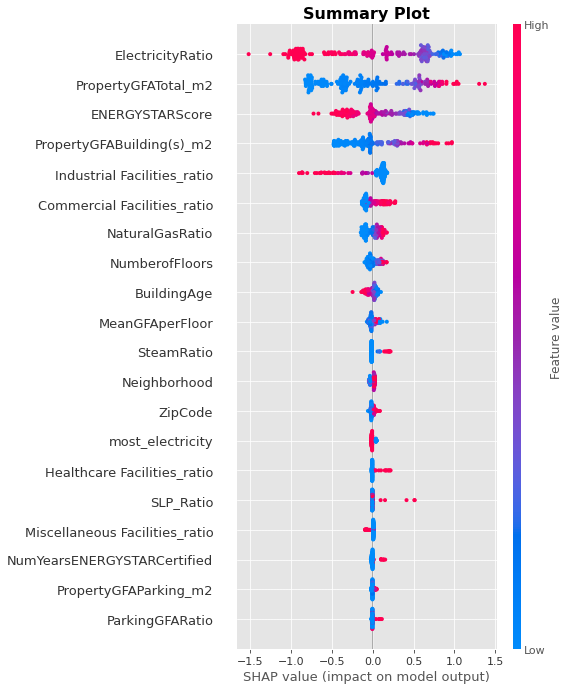

In [45]:
# Create a summary plot
with plt.style.context("ggplot"):
    shap.summary_plot(shap_values, X_test_encoded, feature_names=transformed_col_names, show=False)
    plt.title("Summary Plot", fontsize=16, fontweight='bold')
    plt.show()

In [46]:
shap.initjs()
# Generate the force plot
fp_glb = shap.force_plot(explainer.expected_value, shap_values, features=X_test_encoded, out_names='toxic', link='logit')

# Display the force plot
from IPython.display import display
display(fp_glb)

Using 781 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/196 [00:00<?, ?it/s]

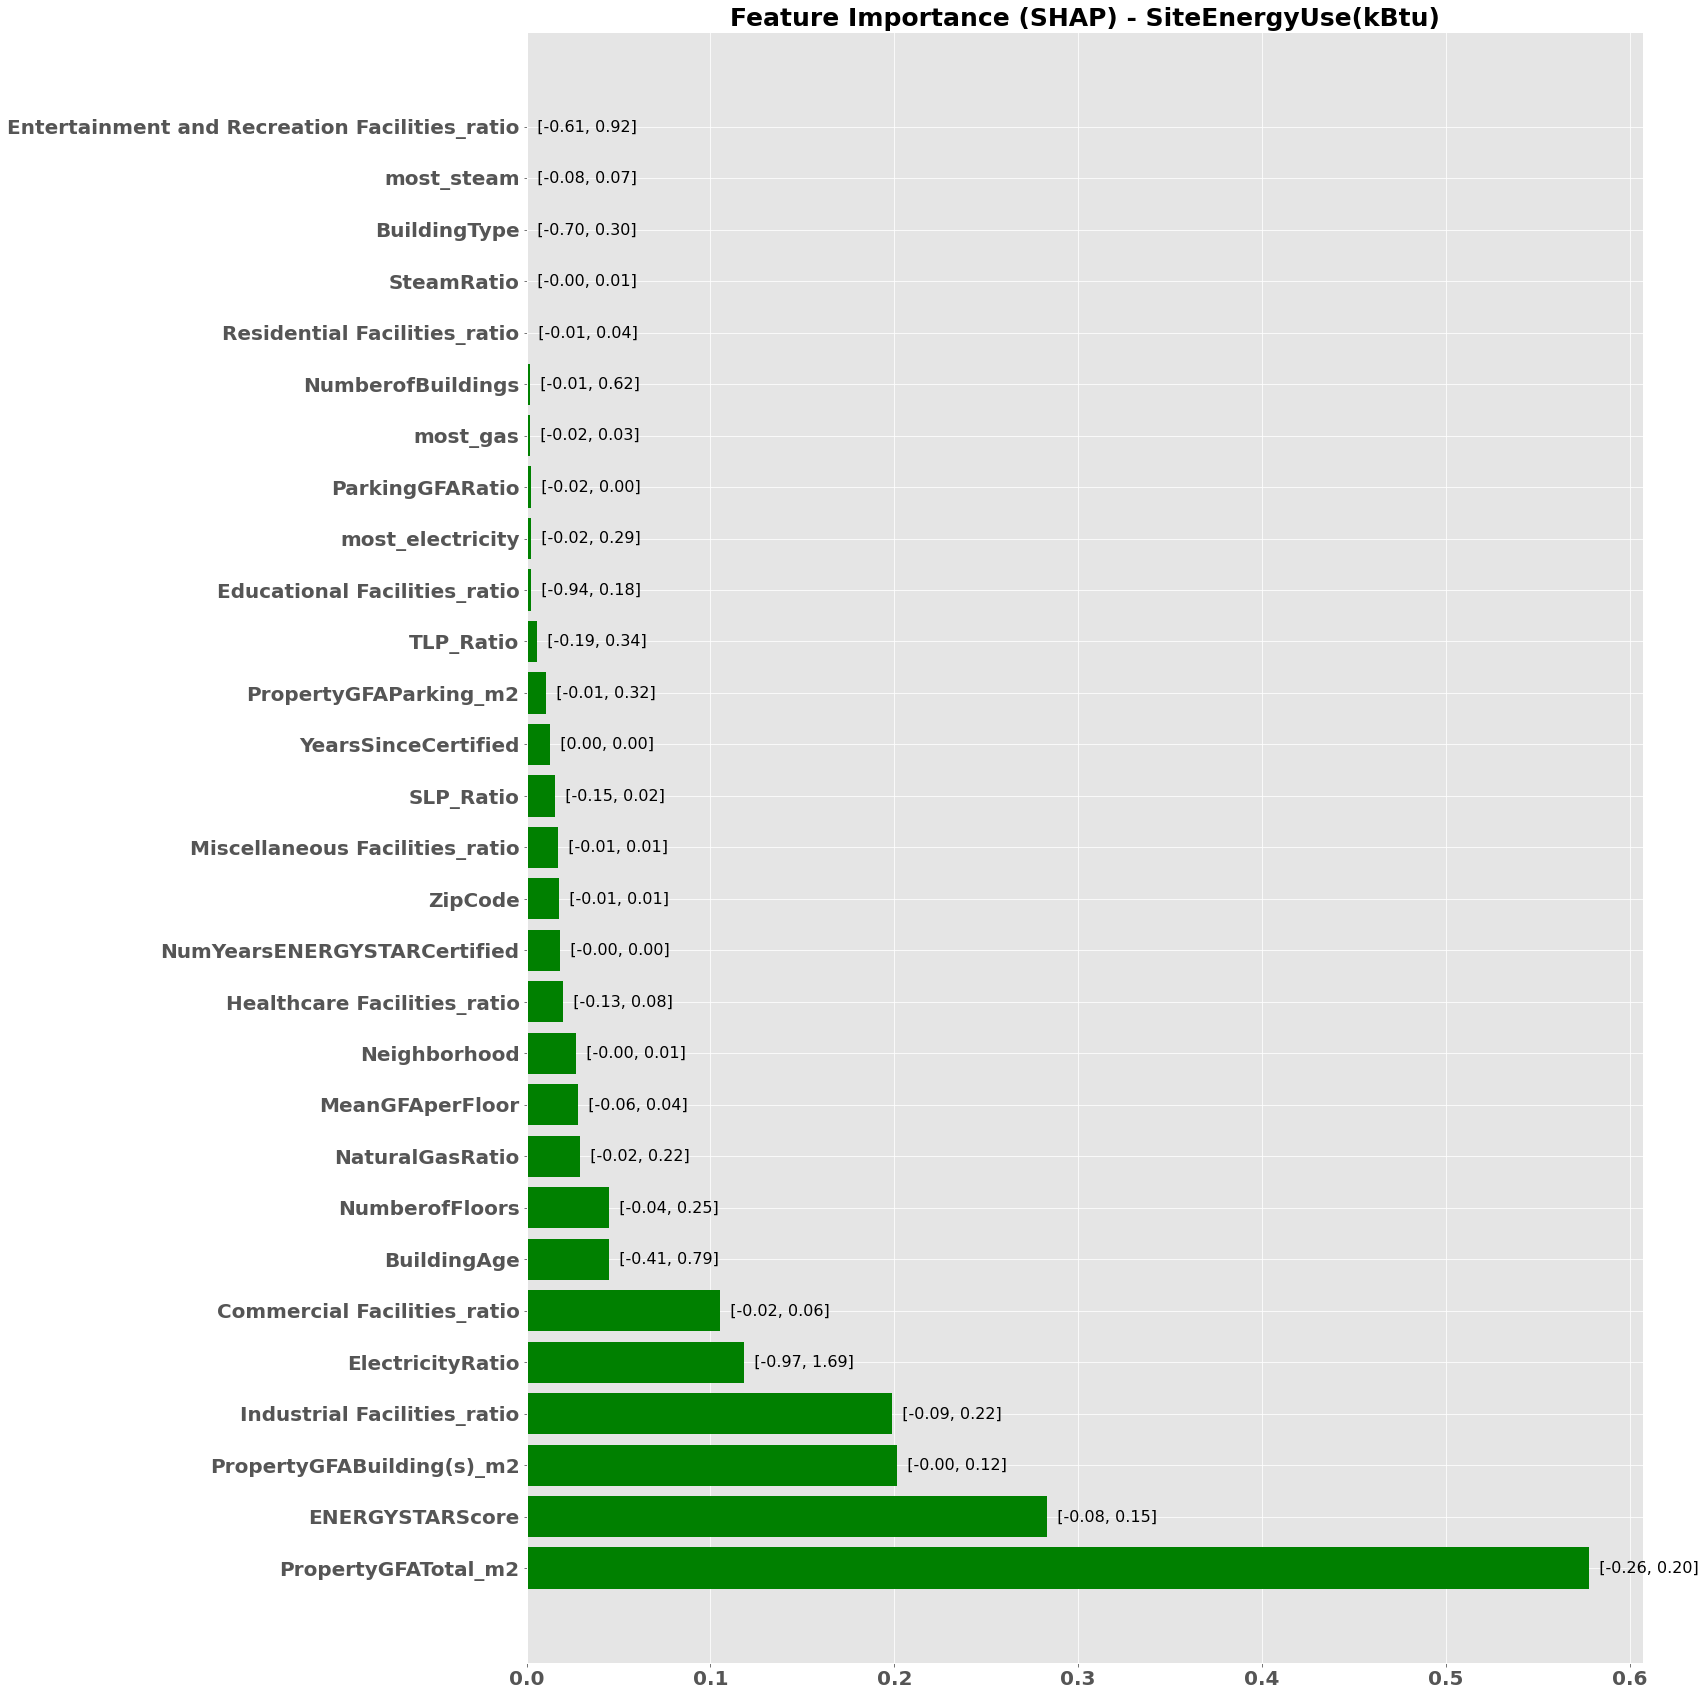

In [47]:

# Create the XGBoost pipeline
lime_xgb_pipeline_energy = Pipeline([
    ('grid_search_energy', xgb_grid_search)
])

lime_xgb_pipeline_energy.fit(X_train_encoded, y_train['log_energie'])
lxp_energy = lime_xgb_pipeline_energy.steps[-1][1]
lxp_energy = lxp_energy.best_estimator_

# Background data summarization
background_summary_energy = shap.sample(X_train_encoded, len(X_train_encoded))

# Kernel SHAP feature importance
explainer_energy = shap.KernelExplainer(lxp_energy.predict, background_summary_energy)
shap_values_energy = explainer_energy.shap_values(X_test_encoded)

# Calculate SHAP feature importances
shap_feature_importances_energy = np.abs(shap_values_energy).mean(axis=0)
sorted_shap_importances_energy = sorted(zip(transformed_col_names, shap_feature_importances_energy), key=lambda x: x[1], reverse=True)

# Plot SHAP feature importances
with plt.style.context("ggplot"):
    fig, ax = plt.subplots(figsize=(20, 30))
    ax.barh(range(len(sorted_shap_importances_energy)), [val for _, val in sorted_shap_importances_energy], color="green")
    ax.set_yticks(range(len(sorted_shap_importances_energy)))
    ax.set_yticklabels([name for name, _ in sorted_shap_importances_energy], fontsize=20, fontweight='bold')
    plt.xticks(fontsize=20, fontweight='bold')
    ax.set_title("Feature Importance (SHAP) - SiteEnergyUse(kBtu)", fontsize=25, fontweight='bold')

    # Add data range information
    for i, (_, importance) in enumerate(sorted_shap_importances_energy):
        min_value = np.min(shap_values_energy[:, i])
        max_value = np.max(shap_values_energy[:, i])
        ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

plt.show()


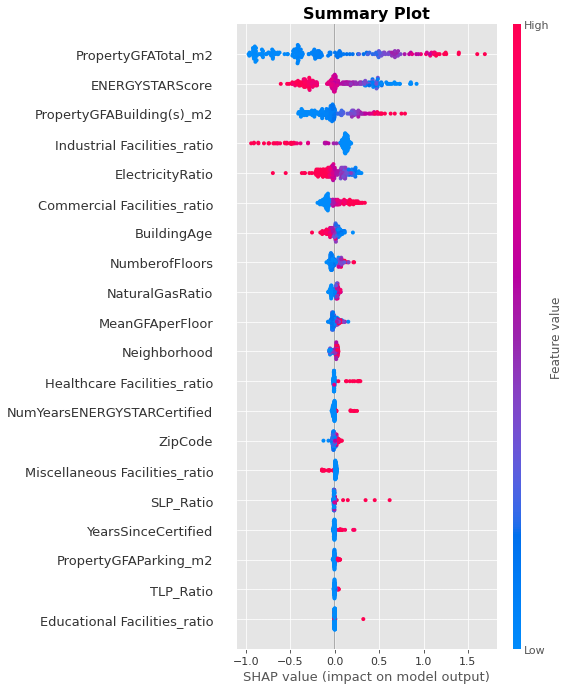

In [48]:
# Create a summary plot
with plt.style.context("ggplot"):
    shap.summary_plot(shap_values_energy, X_test_encoded, feature_names=transformed_col_names, show=False)
    plt.title("Summary Plot", fontsize=16, fontweight='bold')
    plt.show()

In [49]:
shap.initjs()
# Generate the force plot
fp_glb = shap.force_plot(explainer_energy.expected_value, shap_values_energy, features=X_test_encoded, out_names='toxic', link='logit')

# Display the force plot
from IPython.display import display
display(fp_glb)

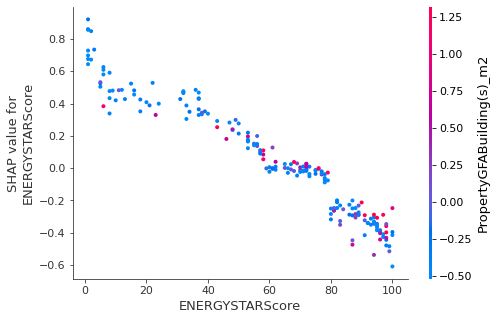

In [50]:
shap.dependence_plot('ENERGYSTARScore', shap_values_energy, X_test_encoded, feature_names=transformed_col_names, show=False)


## SANS ENERGYSCORE

In [51]:
# Définition des noms des colonnes catégorielles et numériques
cat_cols = ['Neighborhood', 'BuildingType', 'ZipCode']
num_cols = [
    'BuildingAge',
    'MeanGFAperFloor',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal_m2',
    'PropertyGFAParking_m2',
    'PropertyGFABuilding(s)_m2',
    'NumYearsENERGYSTARCertified',
    'YearsSinceCertified'
]

other_col = [
    'most_steam',
    'most_electricity',
    'most_gas',
    'Miscellaneous Facilities_ratio',
    'Entertainment and Recreation Facilities_ratio',
    'Educational Facilities_ratio',
    'Commercial Facilities_ratio',
    'Industrial Facilities_ratio',
    'Healthcare Facilities_ratio',
    'Residential Facilities_ratio',
    'ParkingGFARatio',
    'SLP_Ratio',
    'TLP_Ratio',
    'SteamRatio',
    'ElectricityRatio',
    'NaturalGasRatio'
]

In [52]:

# Création du transformateur de colonnes avec encodage target
target_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), num_cols),  # Standardisation des colonnes numériques
        ('target', TargetEncoder(), cat_cols),  # Encodage target des colonnes catégorielles
        ('passthrough', 'passthrough', other_col)  # Passthrough des autres colonnes
    ],
    remainder='drop'
)

# Define the parameters for XGBoost
param_xgb = {
     'n_estimators': [100, 300, 500, 800], 
    # Nombre d'estimateurs dans l'ensemble (plus d'estimateurs peuvent améliorer
    # les performances mais augmentent le temps d'entraînement)
     'learning_rate': [0.1, 0.01], 
# Taux d'apprentissage (contrôle l'ampleur des mises à jour de modèle à chaque étape d'apprentissage)
     'max_depth': [3, 5],  # Profondeur maximale de chaque arbre dans l'ensemble
     'subsample': [0.8],  # Sous-échantillonnage des échantillons d'entraînement pour chaque arbre
     'colsample_bytree': [0.8],  # Sous-échantillonnage des colonnes (variables) pour chaque arbre
     'gamma': [0.1],  # Seuil pour effectuer une division d'un nœud de l'arbre
     'reg_alpha': [0],  # Terme de régularisation L1 (Lasso) pour les poids des feuilles de l'arbre
     'reg_lambda': [0.2]  # Terme de régularisation L2 (Ridge) pour les poids des feuilles de l'arbre
}

# Create the grid search object
xgb_grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_xgb,
    cv=5,
    scoring=('r2', 'neg_mean_absolute_error'),
    refit='r2',
    n_jobs=-1
)

# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('column_transformer', target_transformer),
    ('grid_search', xgb_grid_search)
])


In [53]:
def print_encoding_results(pipeline, encoding_name, target):
    start_time = time.time()
    model = pipeline.fit(X_train, target)
    end_time = time.time()
    training_time = end_time - start_time
    
    best_params = model.named_steps['grid_search'].best_params_
    best_mae_score = np.max(model.named_steps['grid_search'].cv_results_['mean_test_neg_mean_absolute_error'])
    best_r2_score = model.named_steps['grid_search'].best_score_
    
    print("Meilleurs paramètres ({}) :".format(encoding_name), best_params)
    print("Meilleur score MAE ({}) :".format(encoding_name), '{:.3f}'.format(best_mae_score))
    print("Meilleur score R2 ({}) :".format(encoding_name), '{:.3f}'.format(best_r2_score))
    print("Temps d'entraînement ({}) : {:.2f} secondes".format(encoding_name, training_time))



encodings = [("XGBoost", xgb_pipeline)]

target_variables = [("TotalGHGEmissions", y_train['log_emission']),
                    ("SiteEnergyUse(kBtu)", y_train['log_energie'])]

for encoding_name, pipeline in encodings:
    for target_name, target_variable in target_variables:
        print("Encoding:", encoding_name)
        print("Target Variable:", target_name)
        print_encoding_results(pipeline, encoding_name, target_variable)
        print()

Encoding: XGBoost
Target Variable: TotalGHGEmissions
Meilleurs paramètres (XGBoost) : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 0.2, 'subsample': 0.8}
Meilleur score MAE (XGBoost) : -0.465
Meilleur score R2 (XGBoost) : 0.799
Temps d'entraînement (XGBoost) : 5.97 secondes

Encoding: XGBoost
Target Variable: SiteEnergyUse(kBtu)
Meilleurs paramètres (XGBoost) : {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800, 'reg_alpha': 0, 'reg_lambda': 0.2, 'subsample': 0.8}
Meilleur score MAE (XGBoost) : -0.448
Meilleur score R2 (XGBoost) : 0.753
Temps d'entraînement (XGBoost) : 4.69 secondes



In [54]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(np.abs(diff))
    r2 = 1 - (np.sum(diff**2) / np.sum((y_true - np.mean(y_true))**2))
    dict_metrics = {"Métrique": ["MAE", "R²"], "Résultats": [mae, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    df_metrics['Résultats'] = df_metrics['Résultats'].apply(lambda x: '{:.3f}'.format(x))
    return df_metrics

def calculate_metrics(encoding_pipeline, target_variable):
    model = encoding_pipeline.fit(X_train, y_train[target_variable])
    predictions = model.predict(X_test)
    metrics = metrics_model(y_test[target_variable], predictions)
    metrics['Résultats'] = metrics['Résultats']
    return metrics

target_variables = ["log_emission", "log_energie"]

for encoding_name, encoding_pipeline in encodings:
    print("Encodage :", encoding_name)
    for target_variable in target_variables:
        print("Variable cible :", target_variable)
        metrics = calculate_metrics(encoding_pipeline, target_variable)
        print(metrics)
        print()

Encodage : XGBoost
Variable cible : log_emission
  Métrique Résultats
0      MAE     0.456
1       R²     0.801

Variable cible : log_energie
  Métrique Résultats
0      MAE     0.445
1       R²     0.729



In [55]:


def plot_pred_true(y_true, y_pred, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=y_true, y=y_pred, mode='markers', marker=dict(color="#9C3E2D", opacity=0.6), name="Predicted Values"))
    fig.add_trace(go.Scatter(x=[y_true.min(), y_true.max()], y=[y_true.min(), y_true.max()], mode='lines', line=dict(color='red'), name="Bisector"))
    fig.update_layout(xaxis_title="True Values", yaxis_title="Predicted Values", title="Predicted Values vs True Values | Variable {}".format(title), font=dict(size=12))
    return fig

# Créer une figure avec 1 ligne et 2 colonnes
fig = make_subplots(rows=1, cols=2)

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "TotalGHGEmissions" 
# en utilisant XGBoost
xgb_model_GHG = xgb_pipeline.fit(X_train, y_train['log_emission'])
GHG_pred_xgb = xgb_model_GHG.predict(X_test)
fig1 = plot_pred_true(y_test['log_emission'], GHG_pred_xgb, title="TotalGHGEmissions (XGBoost)")
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig1.data[1], row=1, col=1)
fig.add_annotation(x=0.05, y=0.99, xref='paper', yref='paper', text="TotalGHGEmissions (XGBoost)",\
                   showarrow=False, font=dict(size=18))

# Tracer les valeurs prédites par rapport aux valeurs réelles pour la variable cible "SiteEnergyUse(kBtu)" 
# en utilisant RandomForestRegressor
xgb_model_SUE = xgb_pipeline.fit(X_train, y_train['log_energie'])
SiteEnergy_pred_xgb = xgb_model_SUE.predict(X_test)
fig2 = plot_pred_true(y_test['log_energie'], SiteEnergy_pred_xgb, title="SiteEnergyUse(kBtu) (XGBoost)")
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig2.data[1], row=1, col=2)
fig.add_annotation(x=0.99, y=0.99, xref='paper', yref='paper', text="SiteEnergyUse(kBtu) (XGBoost)",\
                   showarrow=False, font=dict(size=18))

fig.update_layout(title_text="Valeurs prédites vs Valeurs réelles | Pipelines d'apprentissage automatique",\
                  height=500, width=1000)
fig.show()



## Feature Importance

In [56]:
# Fit the column transformer on the training data
target_transformer.fit_transform(X_train, y_train['log_emission'])

# Get the transformed column names
transformed_col_names = num_cols + list(target_transformer.named_transformers_['target'].get_feature_names_out(cat_cols)) + other_col

# Print the resulting column name
display(transformed_col_names)

['BuildingAge',
 'MeanGFAperFloor',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal_m2',
 'PropertyGFAParking_m2',
 'PropertyGFABuilding(s)_m2',
 'NumYearsENERGYSTARCertified',
 'YearsSinceCertified',
 'Neighborhood',
 'BuildingType',
 'ZipCode',
 'most_steam',
 'most_electricity',
 'most_gas',
 'Miscellaneous Facilities_ratio',
 'Entertainment and Recreation Facilities_ratio',
 'Educational Facilities_ratio',
 'Commercial Facilities_ratio',
 'Industrial Facilities_ratio',
 'Healthcare Facilities_ratio',
 'Residential Facilities_ratio',
 'ParkingGFARatio',
 'SLP_Ratio',
 'TLP_Ratio',
 'SteamRatio',
 'ElectricityRatio',
 'NaturalGasRatio']

In [57]:
X_train_encoded = pd.DataFrame(target_transformer.transform(X_train), columns=transformed_col_names)
X_test_encoded = pd.DataFrame(target_transformer.transform(X_test), columns=transformed_col_names)

In [58]:
# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('grid_search', xgb_grid_search)
])

def plot_feature_importance(X, y, target_name):
    # Fit the XGBoost pipeline and get the best estimator
    xgb_pipeline.fit(X, y)
    xp = xgb_pipeline.steps[-1][1].best_estimator_

    # Perform feature importance analysis
    sorted_indices = np.argsort(xp.feature_importances_)
    sorted_importances = xp.feature_importances_[sorted_indices]
    sorted_col_names = [transformed_col_names[i] for i in sorted_indices]

    # Plot the feature importances
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_importances)), sorted_importances, color=["red" if importance < 0 else "green" for importance in sorted_importances])
        ax.set_yticks(range(len(sorted_col_names)))
        ax.set_yticklabels(sorted_col_names, fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Feature Importance ({target_name})", fontsize=25, fontweight='bold')

    plt.show()

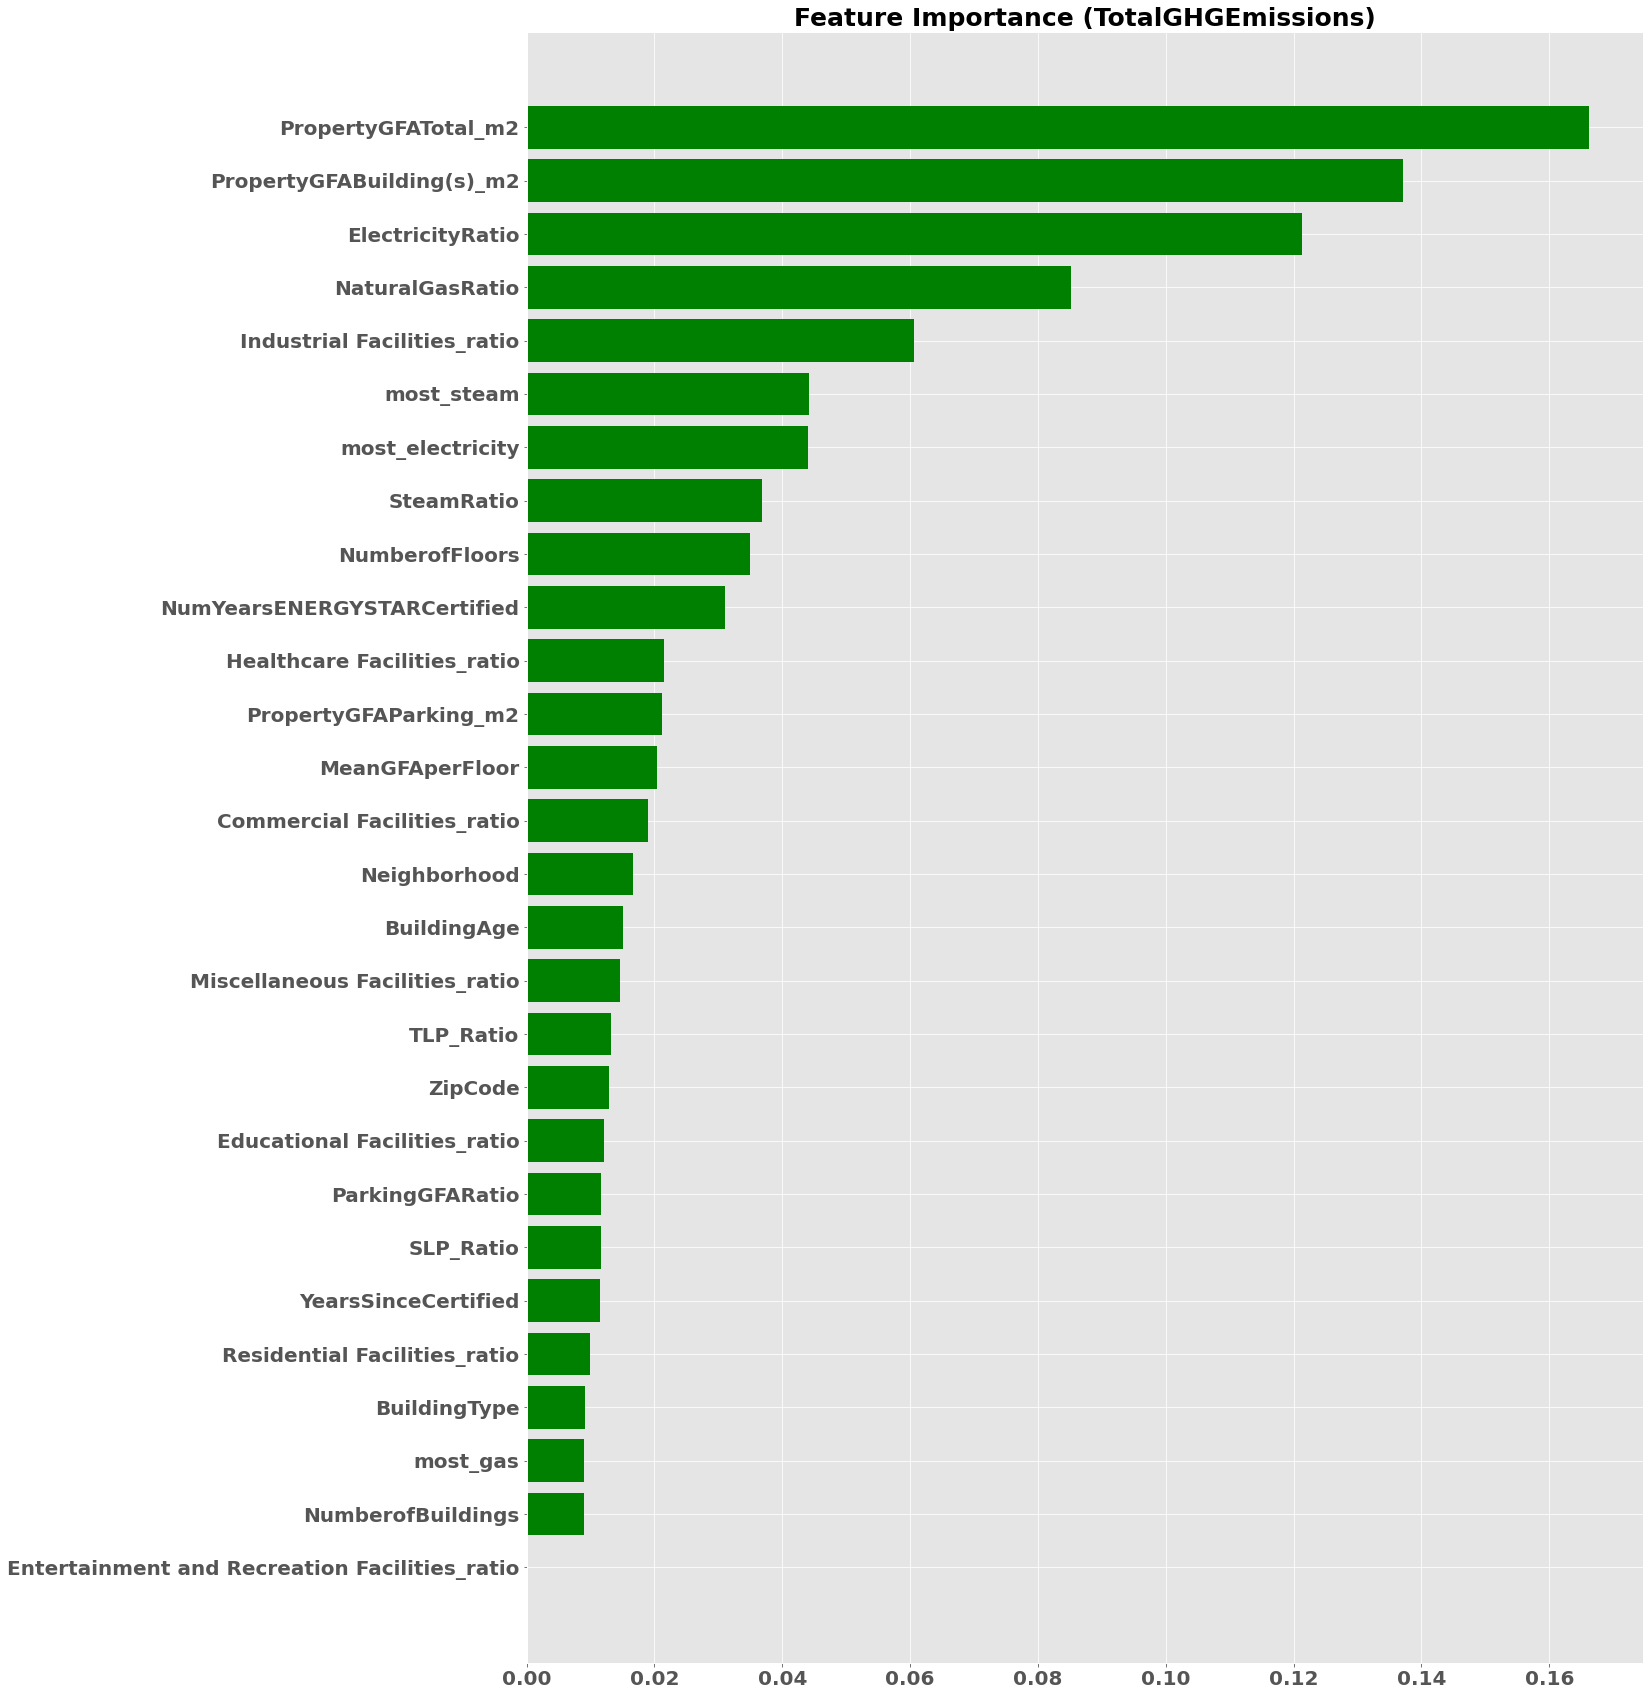

In [59]:
# Plot feature importance for 'TotalGHGEmissions' column
plot_feature_importance(X_train_encoded, y_train['log_emission'], 'TotalGHGEmissions')

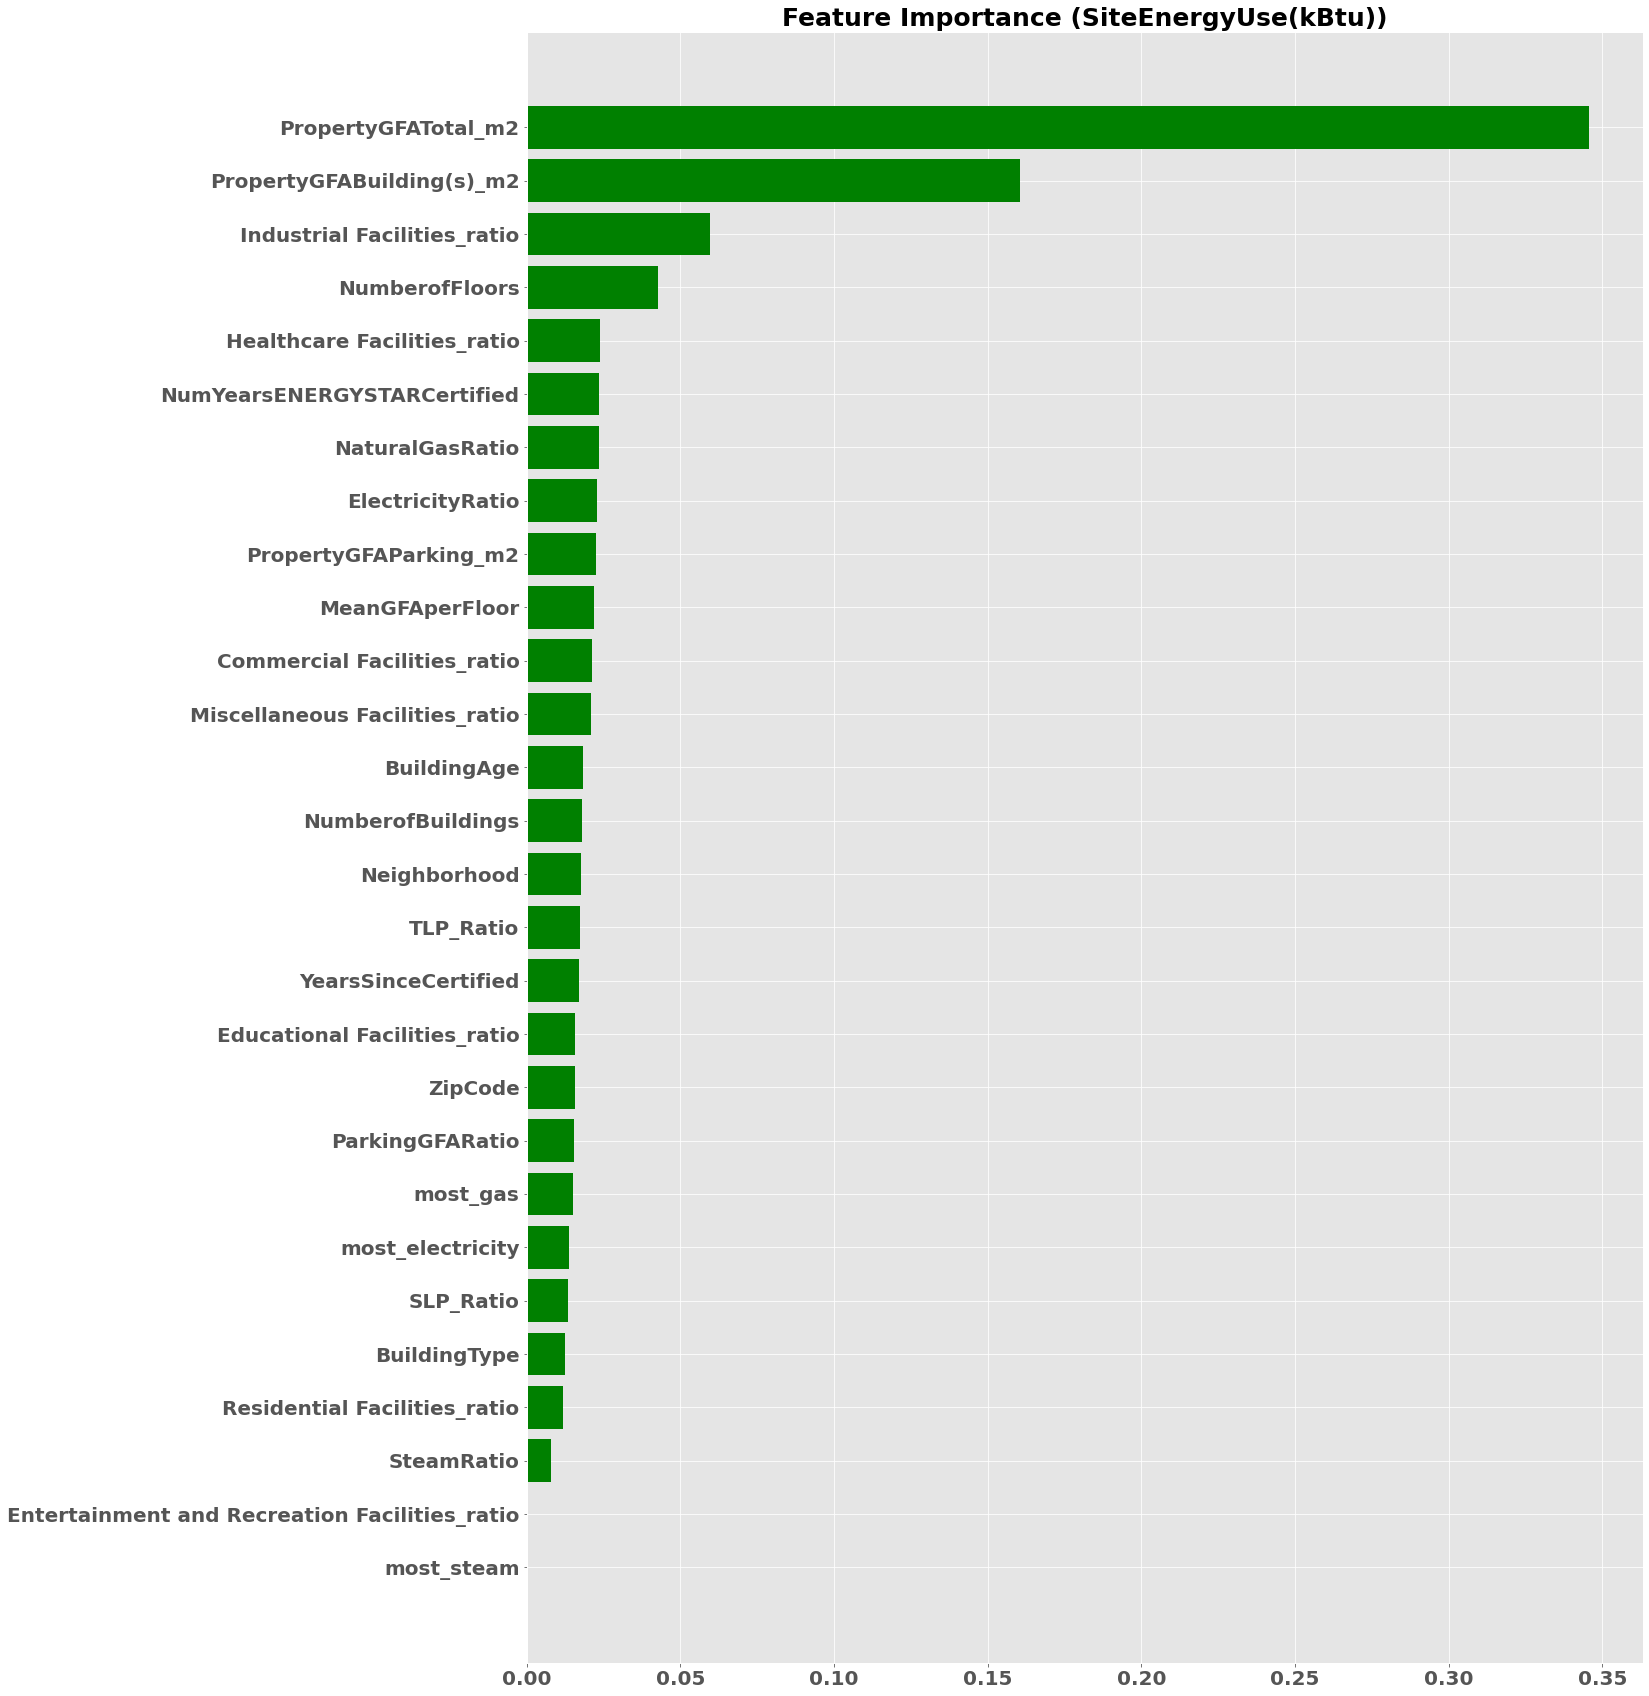

In [60]:
# Plot feature importance for 'SiteEnergyUse(kBtu)' column
plot_feature_importance(X_train_encoded, y_train['log_energie'], 'SiteEnergyUse(kBtu)')

## SHAP

In [61]:
shap.initjs()


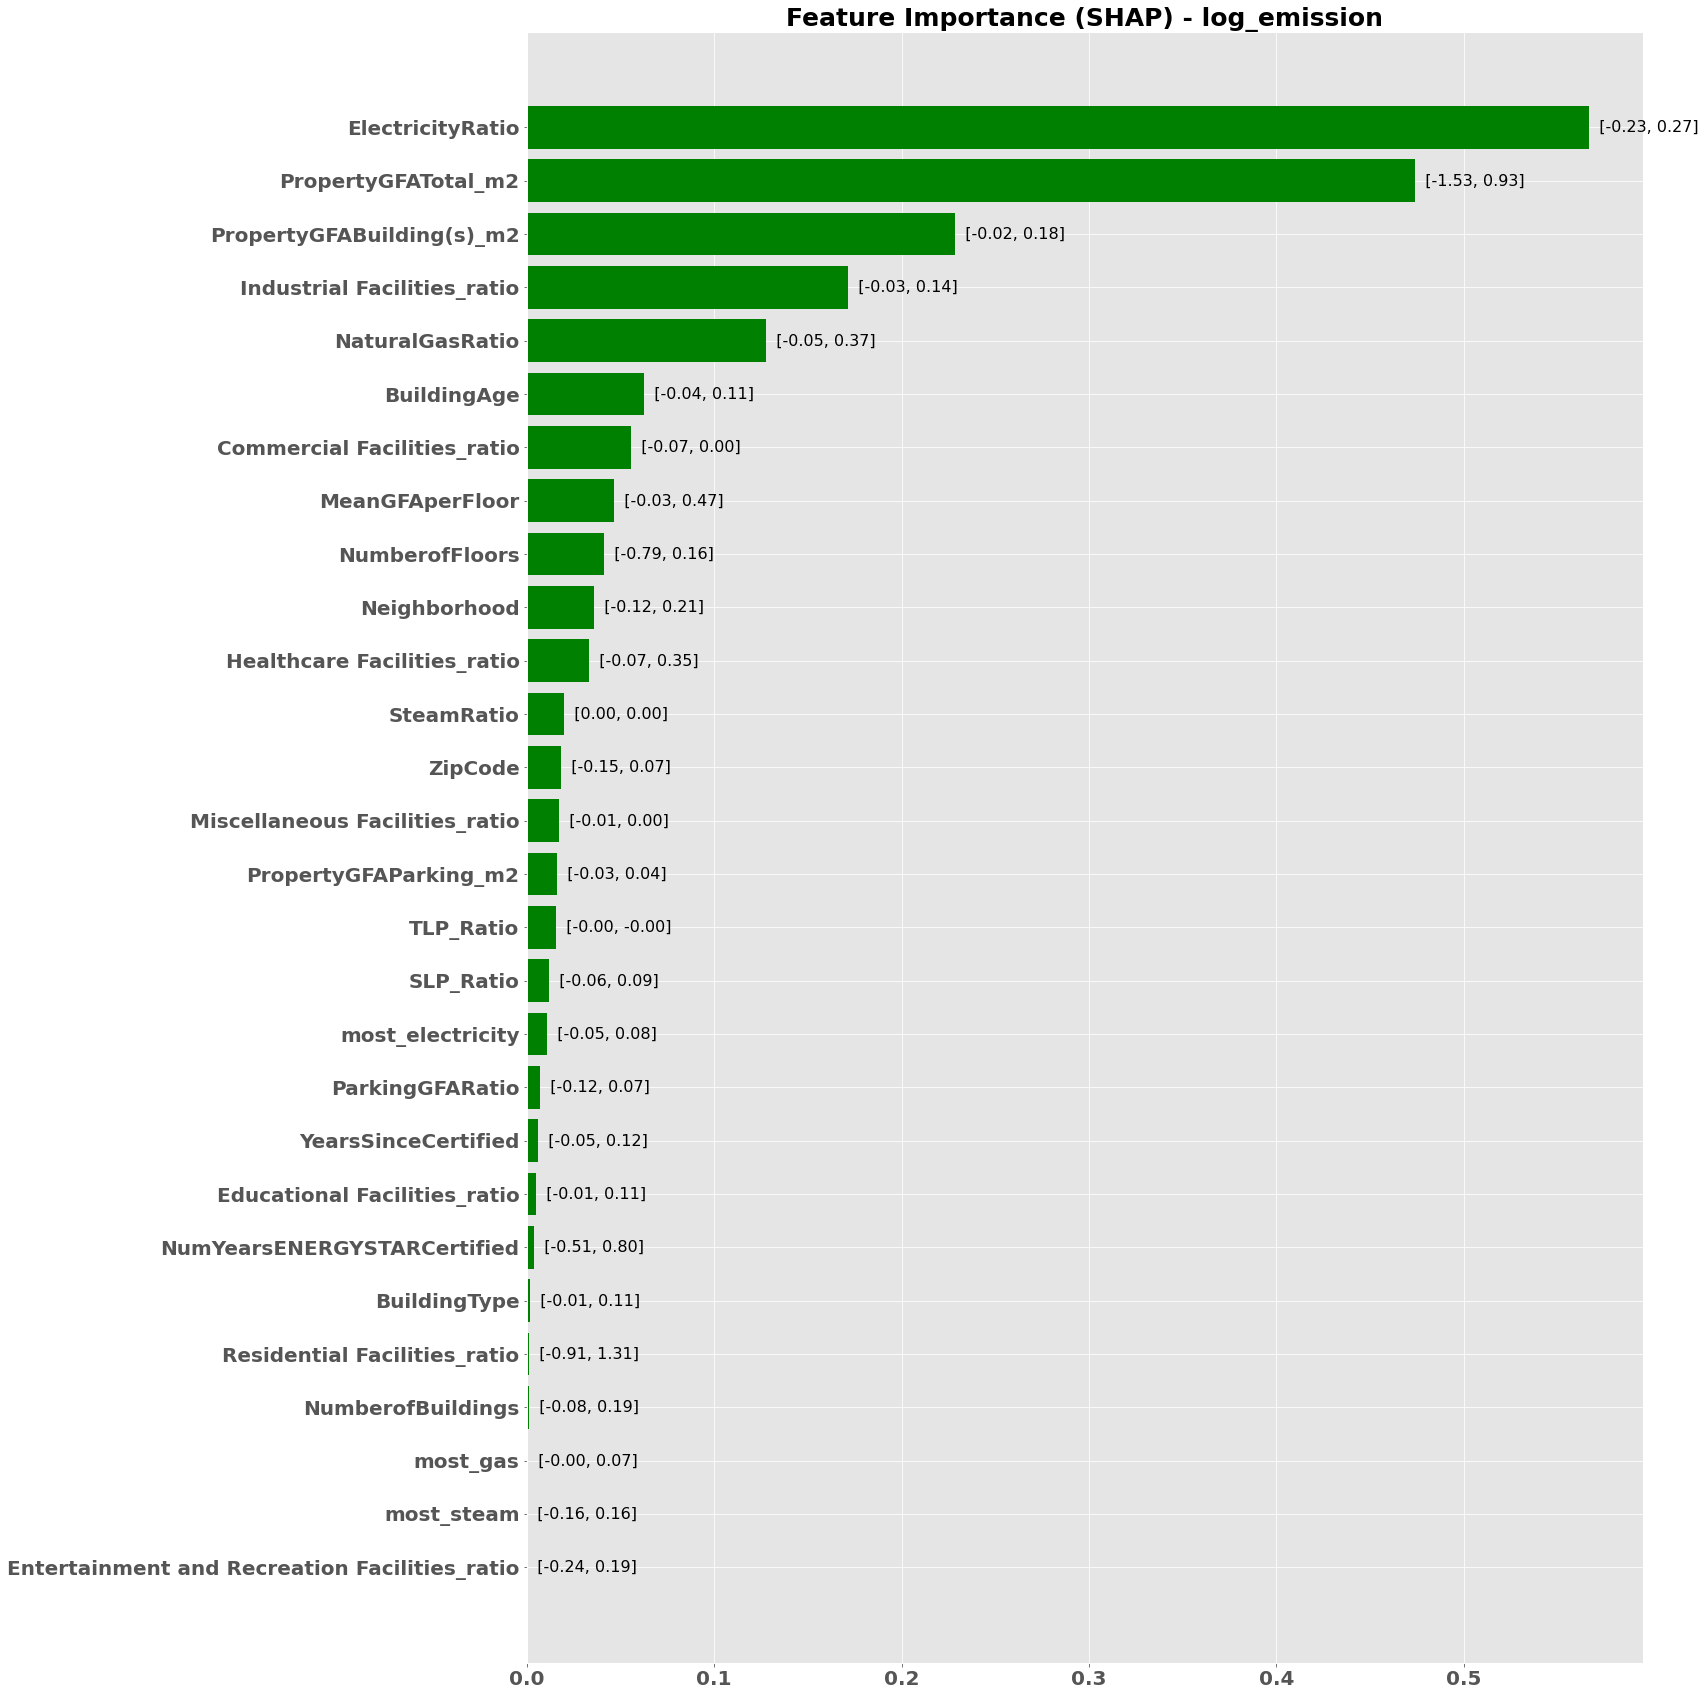

In [62]:
def plot_shap_feature_importance(column_name):
    # Create the XGBoost pipeline
    shap_xgb_pipeline = Pipeline([
        ('grid_search', xgb_grid_search)
    ])

    shap_xgb_pipeline.fit(X_train_encoded, y_train[column_name])
    sxp = shap_xgb_pipeline.steps[-1][1]
    sxp = sxp.best_estimator_

    # SHAP feature importance
    explainer = shap.TreeExplainer(sxp)
    shap_values = explainer.shap_values(X_test_encoded)

    # Calculate SHAP feature importances
    shap_feature_importances = np.abs(shap_values).mean(axis=0)
    sorted_shap_importances = sorted(zip(transformed_col_names, shap_feature_importances), key=lambda x: x[1], reverse=False)

    # Plot SHAP feature importances
    with plt.style.context("ggplot"):
        fig, ax = plt.subplots(figsize=(20, 30))
        ax.barh(range(len(sorted_shap_importances)), [val for _, val in sorted_shap_importances], color="green")
        ax.set_yticks(range(len(sorted_shap_importances)))
        ax.set_yticklabels([name for name, _ in sorted_shap_importances], fontsize=20, fontweight='bold')
        plt.xticks(fontsize=20, fontweight='bold')
        ax.set_title(f"Feature Importance (SHAP) - {column_name}", fontsize=25, fontweight='bold')

        # Add data range information
        for i, (_, importance) in enumerate(sorted_shap_importances):
            min_value = np.min(shap_values[:, i])
            max_value = np.max(shap_values[:, i])
            ax.text(importance, i, f"  [{min_value:.2f}, {max_value:.2f}]", va='center', fontsize=16)

    plt.show()

# Call the function for 'TotalGHGEmissions' column
plot_shap_feature_importance('log_emission')


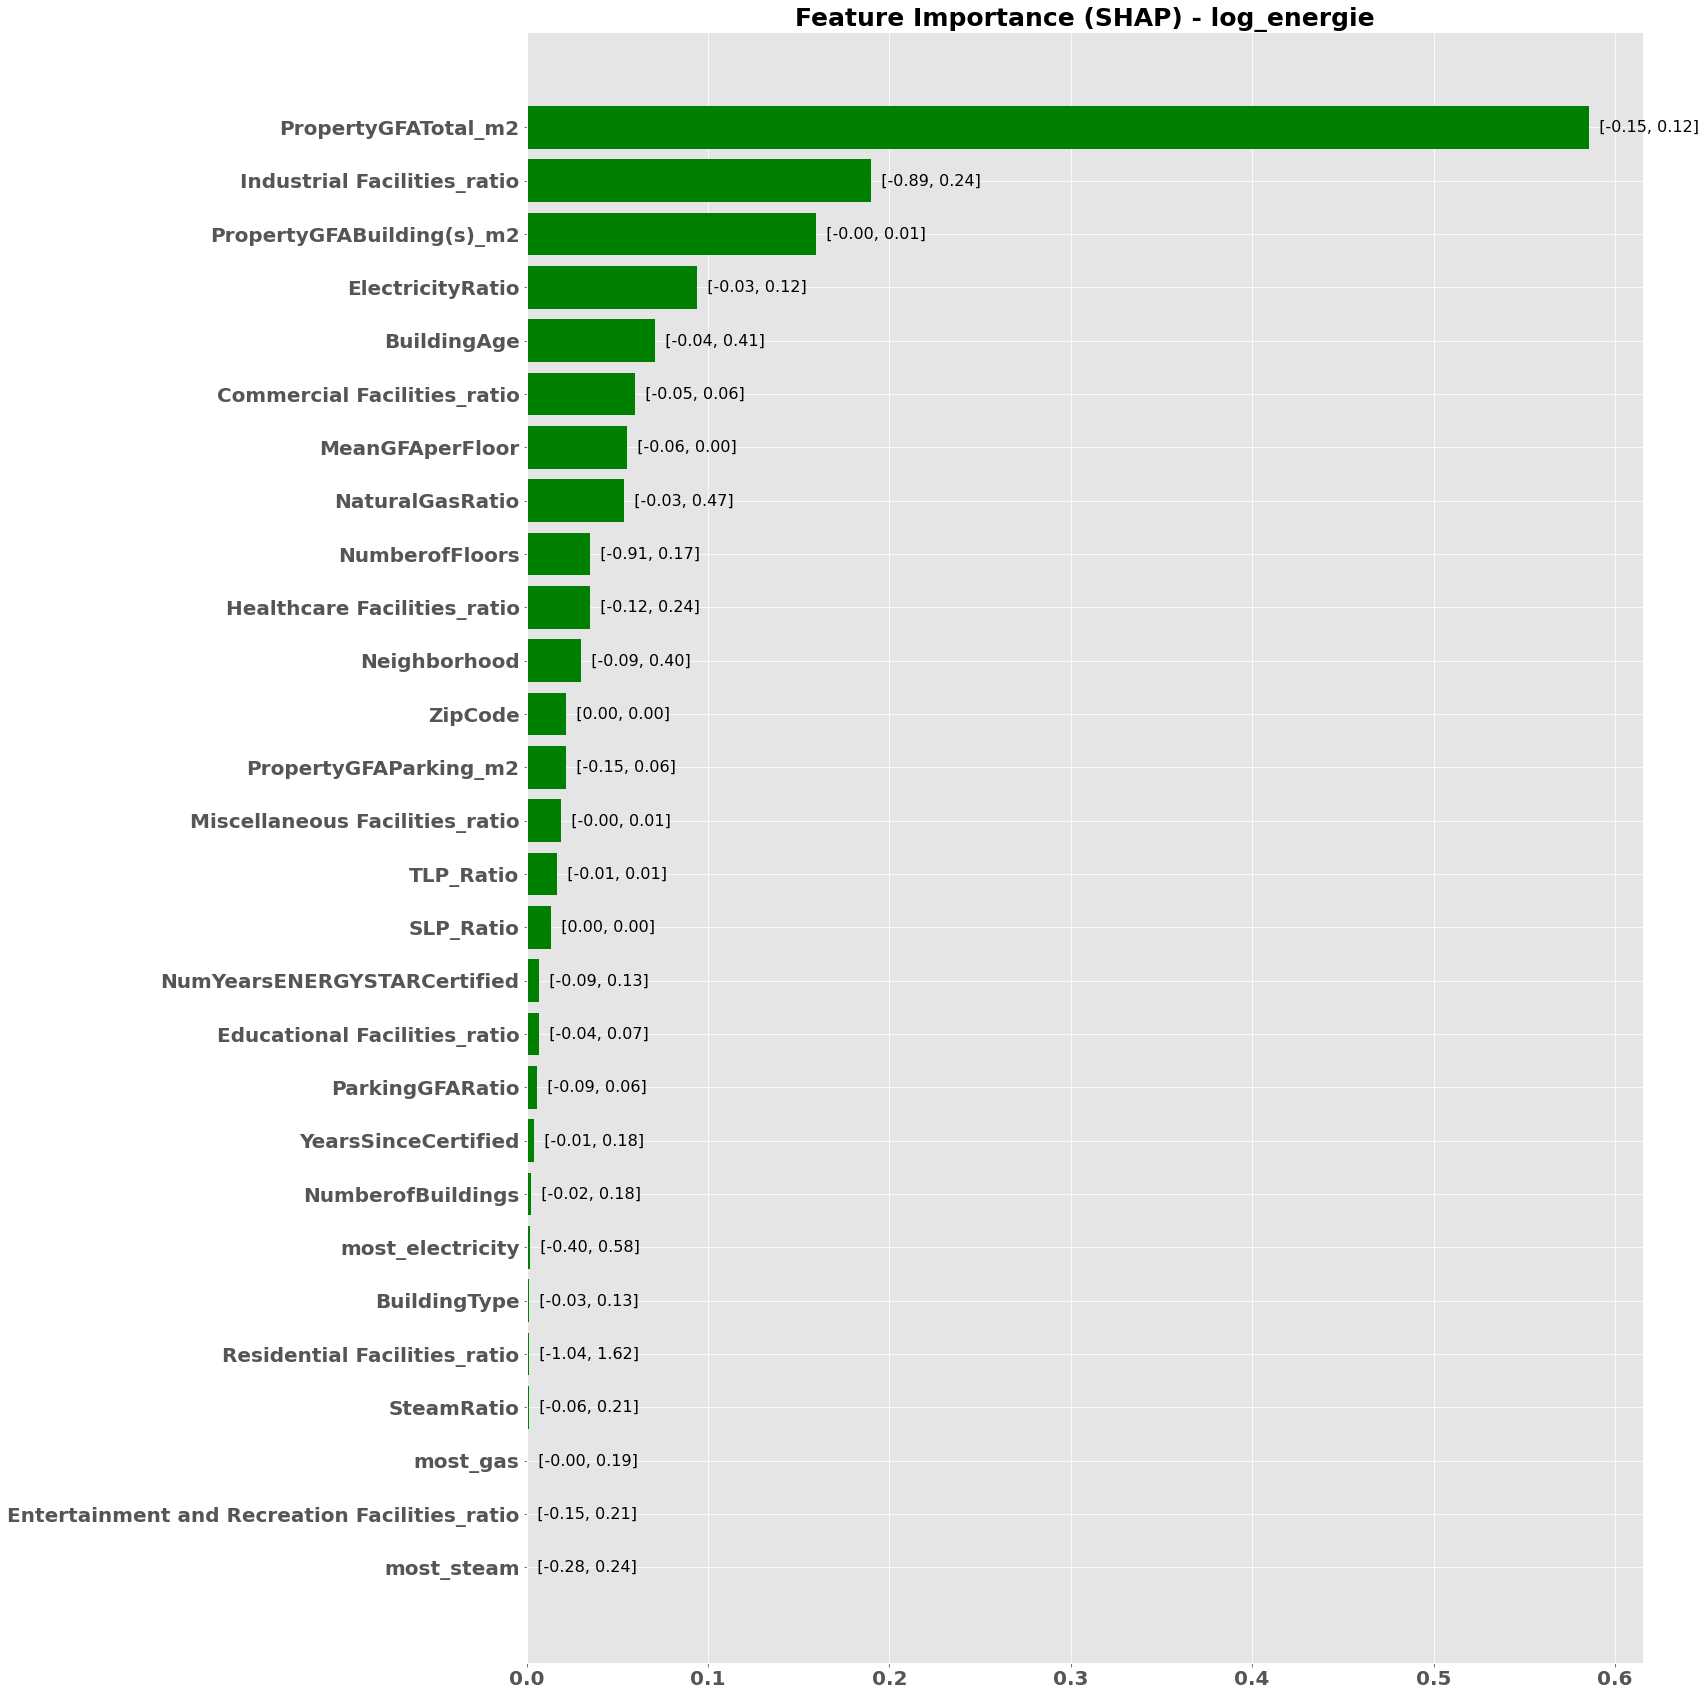

In [63]:
# Call the function for 'SiteEnergyUse(kBtu)' column
plot_shap_feature_importance('log_energie')